In [1]:
# Import Packages
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np 
from tqdm import tqdm 
import metpy 
from metpy.units import units 
import metpy.calc as mpcalc
from metpy.plots import SkewT
import os 
import wrf 
import glob
import pandas as pd 
from IPython.display import HTML, display 
import imageio
from itertools import product
from scipy.interpolate import RegularGridInterpolator, interp1d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import random as random 
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy.stats import linregress
import pickle
from scipy.stats import gaussian_kde
from IPython.display import Markdown


Cannot import USCOUNTIES and USSTATES without Cartopy installed.


In [2]:
# Establish Model Path
model_path = '/storage/group/pmm116/default/bsh5393/cm1sims/'

# Simulation Paths
sim_paths = sorted(glob.glob(model_path + '*SIM*'))
# Sorting function
sim_paths = sorted(sim_paths, key=lambda x: int(x.split('SIM')[1].split('_')[0]))

# Simulation Names
sim_names = sorted(os.listdir(sim_paths[0]))
sim_names = [name for name in sim_names if 'cm1out_00' in name]

# Actual Names of Each Run
run_names = sorted(os.listdir(model_path))
#run_names.remove('cm1test')
#run_names.remove('cm1test2')
#run_names.remove('test_101158')
run_names = sorted(run_names, key=lambda x: int(x.split('SIM')[1].split('_')[0]))

# Create Global Variables
sample_sim = xr.open_dataset(sim_paths[0]+ '/' + sim_names[0])

# Grid Points
x_grid = sample_sim['xf']
y_grid = sample_sim['yf']
z_grid = sample_sim['zf']

# Scalar Points
x_data = sample_sim['xh']
y_data = sample_sim['yh']
z_data = sample_sim['zh']

# Time Array
time = np.linspace(0, 120, 25, dtype='int')

# Following Cells Discern the Non-Tornadic, Weakly Tornadic (EF0-EF1), and Signif. Tornadic (EF2+) using code from the Tornado Tracking Script.

In [3]:
# This Cell Computes Max Wind for associate pressure differentials
def comp_velo(sim_path, psfcmin):
    
    # define mean pressure (need to interpolate down to the surface since the lowest model level is 7.5 m)
    
    # read in first 3 pressure levels
    press = xr.open_dataset(sim_path + '/' 
                                + sim_names[0])['prs'].isel(time=0, zh = slice(0,3), yh = 0, xh = 0).values
    # constants of taylor approximation/expansion
    c1 = 1.875
    c2 = -1.25
    c3 = 0.375
    
    # compute mean surface pressure
    mean_pres = c1*press[0] + c2*press[1] + c3*press[2]
    
    # define density 
    rho = 1.16 # kg/m^3
    
    # Compute Pressure Differential
    diff_pres = np.abs(mean_pres-psfcmin)
    
    # compute velocity
    max_v = np.sqrt(diff_pres/rho)
    
    return max_v;

In [4]:
# Create A Function That Tracks General Storm Motion

# Criteria: First guess at updraft location is locating the updraft velocity maxima at z = 2km at t1 & t2

# Additional Search: Compute UH (2 - 5 km) in approximately a 18 km by 18 km box surrounding the first guess at each analysis time
# and find the UH maxima at each time 

# Compute adjusted storm motion by adding observed motion of storm in CM1 grid (input 
# soundings have original storm motion , (12.2, 12.5), subtracted off so any additional 
# motion observed is deviations from this mean value)

def sm_adjusted(sim_path, t1, t2):
    # Height index Corresponding to z = 2 km
    z_2km = np.argmin(np.abs(z_data.values-2))
    z_5km = np.argmin(np.abs(z_data.values -5))
    
    # STEP1: Find approximate locations using first guess: restrict search to yh = +- 22.5 km to avoid picking up on the LM supercell
    
    # Read in Vertical Velocity 
    winterp_i = xr.open_dataset(sim_path + '/' + sim_names[t1])['winterp'].isel(time = 0, zh = z_2km, yh = slice(550, 1125))
    winterp_f = xr.open_dataset(sim_path + '/' + sim_names[t2])['winterp'].isel(time = 0, zh = z_2km, yh = slice(550, 1125))
    # Find Velocity Maxima (adjust yh indices back to original grid since we took a slice, and the current yh index is relative to that slice)
    yh_i, xh_i = np.unravel_index(winterp_i.argmax(), winterp_i.shape)
    yh_f, xh_f = np.unravel_index(winterp_f.argmax(), winterp_f.shape)
    yh_i = yh_i + 550
    yh_f = yh_f + 550
    
    # STEP2: Use First Guess to grab vorticity and vertical velocity clouds to compute UH
    
    # Zeta
    zeta_i = xr.open_dataset(sim_path + '/' + sim_names[t1])['zvort'].isel(time = 0, zh = slice(z_2km, z_5km+1),
                                                                           yh = slice(yh_i - 125, yh_i + 125),
                                                                           xh = slice(xh_i - 125, xh_i + 125))
    zeta_f = xr.open_dataset(sim_path + '/' + sim_names[t2])['zvort'].isel(time = 0, zh = slice(z_2km, z_5km+1),
                                                                           yh = slice(yh_f - 125, yh_f + 125),
                                                                           xh = slice(xh_f - 125, xh_f + 125))
    # Vertical Velocity
    w_i = xr.open_dataset(sim_path + '/' + sim_names[t1])['winterp'].isel(time = 0, zh = slice(z_2km, z_5km+1),
                                                                           yh = slice(yh_i - 125, yh_i + 125),
                                                                           xh = slice(xh_i - 125, xh_i + 125))
    w_f = xr.open_dataset(sim_path + '/' + sim_names[t2])['winterp'].isel(time = 0, zh = slice(z_2km, z_5km+1),
                                                                           yh = slice(yh_f - 125, yh_f + 125),
                                                                           xh = slice(xh_f - 125, xh_f + 125))
    # STEP 3: Compute 2-5 km UH
    
    # Start summation at 0 and determine spacing between height levels
    UH_i = 0
    UH_f = 0
    dz = 1000*np.diff(z_data[z_2km: z_5km+1].values)
    # Loop to compute UH    
    for z in np.arange(0, z_5km - z_2km-1, 1):
        UH_i = UH_i + (1/4)*(zeta_i.isel(zh=z).values + zeta_i.isel(zh = z+1)).values*(w_i.isel(zh=z).values 
                                                                                       + w_i.isel(zh = z+1).values)*dz[z]
        UH_f = UH_f + (1/4)*(zeta_f.isel(zh=z).values + zeta_f.isel(zh = z+1)).values*(w_f.isel(zh=z).values
                                                                                       + w_f.isel(zh = z+1).values)*dz[z]
        
    # STEP 4: Find UH Maxima 
    y_i, x_i = np.unravel_index(UH_i.argmax(), UH_i.shape)
    y_f, x_f = np.unravel_index(UH_f.argmax(), UH_f.shape)
        
    # Shift indices back to regular grid based off of original slice bounds
    x_i = x_i + (xh_i - 125)
    y_i = y_i + (yh_i - 125)
    x_f = x_f + (xh_f - 125)
    y_f = y_f + (yh_f - 125)
    
    # STEP 5: Compute New Storm Motion
    
    # Original Storm Motion (m/s)
    mean_u = 12.2 
    mean_v = 12.5
    
    # New Storm Motion (CHANGE THIS BACK EVENTUALLY BY REMOVING THE 12 WHEN ENTIRE ENSEMBLE IS RERUN)
    u_adj = mean_u + 1000*(x_data[x_f] - x_data[x_i]).values/(300*(t2-t1))
    v_adj = mean_v + 1000*(y_data[y_f] - y_data[y_i]).values/(300*(t2-t1))
        
    # FINAL STEP: Return the Storm Locations and Adjusted Storm Motion
    # Format: (u, v), (y_i, x_i), (y_f, x_f)
    return [(u_adj, v_adj), (y_i, x_i), (y_f, x_f)];
        

In [5]:
# INCORRECT FUNCTION: Keeping for book-keeping purposes (the correct method is the first guess using 2km updraft velocity)

# Create A Function that computes the true storm motion 
# (accounts for the deviation from the average  storm motion from the parent environment 
# by roughly computing the additional observed motion over the last hour of each simulation)

def sm_adjust(sim_path):
    
    # Average Storm Motion from parent storm environment
    mean_u = 12.2
    mean_v = 12.5
    
    # Read in pressure data at t = 1 & 2 hrs 
    pres_i = xr.open_dataset(sim_path + '/' + sim_names[12])['prs'].isel(time=0, zh =0)
    pres_f = xr.open_dataset(sim_path + '/' + sim_names[-1])['prs'].isel(time=0, zh =0)
    
    # Find the indices of minimum pressure to track the updraft center (approximate storm) propogation
    ind_i = np.unravel_index(pres_i.argmin(), pres_i.shape) # t = 1 hr
    ind_f = np.unravel_index(pres_f.argmin(), pres_f.shape) # t = 2 hr
    
    # Compute the Additional Observed Storm Motion (m/s)
    obs_u = 1000*(x_data[ind_f[-1]] - x_data[ind_i[-1]]).values/3600
    obs_v = 1000*(y_data[ind_f[0]] - y_data[ind_i[0]]).values/3600
    
    # Compute adjusted storm motion
    adjust_u = mean_u + obs_u
    adjust_v = mean_v + obs_v
    
    # Return Adjusted Storm Motion and also the indices of pressure minimums
    return ((adjust_u, adjust_v), (ind_f, ind_i));

100%|██████████| 30/30 [00:00<00:00, 1832.77it/s]


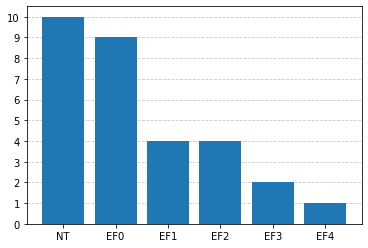

In [6]:
# Create a cell that stores the ground relative wind for each simulation based on the cm1out_stats file

TLV_tracker = {}

for sim in tqdm(range(len(sim_paths))):
    # Read in Stats File For Each Simulation
    stats = xr.open_dataset(sim_paths[sim] + '/cm1out_stats.nc')
    
    # Compute Max GR_wind and Read in Max Vert Vorticity
    min_press = stats['psfcmin']
    vort = stats['vortsfc'] 
    max_wind = comp_velo(sim_paths[sim], min_press)
    
    # Find Points where gr_wind > 29 and vort > 0.25 and save them (gr_wind, zvort)
    tracks = np.zeros((len(stats['time']), 2))
    for x in range(tracks.shape[0]):
        if (max_wind[x] >= 26):
            tracks[x] = [max_wind[x], vort[x]]
    # Save the Tracks for Each Simulation
    TLV_tracker[run_names[sim]] = tracks

# -------------------------------------------------------------------------------------------------------------

# Apply Ratings to TLV Tracker

# Rough Enhanced Fujita Scale Wind 
EF0_low = 26 #29
EF0_high = 34 #38 
EF1_low = 34 #38
EF1_high = 44 #49
EF2_low = 44 #49
EF2_high = 54 #60
EF3_low = 54 #60
EF3_high = 65# 73
EF4_low = 65# 73
EF4_high = 80 #89
EF5 = 80 #89

# Apply Ratings
TLV_ratings = {}
for sim in tqdm(range(len(run_names))):
    # Empty Array for Ratings
    ratings = np.empty((len(TLV_tracker[run_names[sim]])), dtype='<U10')
    # Determine Rating
    for t in range(len(ratings)):
        gr_wind = TLV_tracker[run_names[sim]][t, 0]
        
         # EF0 Criteria
        if (gr_wind > EF0_low) & (gr_wind < EF0_high):
            ratings[t] = 'EF0'
            
        # EF1 Criteria
        if (gr_wind > EF1_low) & (gr_wind < EF1_high):
            ratings[t] = 'EF1'
            
        # EF2 Criteria
        if (gr_wind > EF2_low) & (gr_wind < EF2_high):
            ratings[t] = 'EF2'
            
        # EF3 Criteria
        if (gr_wind > EF3_low) & (gr_wind < EF3_high):
            ratings[t] = 'EF3'
            
        # EF4 Criteria
        if (gr_wind > EF4_low) & (gr_wind < EF4_high):
            ratings[t] = 'EF4'
            
        # EF5 Criteria 
        if (gr_wind > EF5):
            ratings[t] = 'EF5'
        
        # No Tornado
        if (gr_wind == np.nan):
            ratings[t] = 'None'
    # Save Ratings
    TLV_ratings[run_names[sim]] = ratings
    
# Create a histogram of highest rating acquired by each simulation
hist_rating = np.zeros((len(run_names)), dtype=int)

# First figure out the highest rating achieved by each simulation and save it
for sim in tqdm(range(len(run_names))):
    # Read in the list of ratings for each simulation
    ratings = TLV_ratings[run_names[sim]]
    rate = np.zeros((len(ratings)), dtype = int)
    # iterate over each rating per simulation and save the highest rating only
    for x in range(len(ratings)):
        # check for each individual rating
        if ratings[x] == '':
            rate[x] = 0
        if ratings[x] == 'EF0':
            rate[x] = 1
        if ratings[x] == 'EF1':
            rate[x] = 2
        if ratings[x] == 'EF2':
            rate[x] = 3
        if ratings[x] == 'EF3':
            rate[x] = 4
        if ratings[x] == 'EF4':
            rate[x] = 5
        if ratings[x] == 'EF5':
            rate[x] = 6 
    # Save highest rating for each simulation
    hist_rating[sim] = rate.max()

# -------------------------------------------------------------------------------------------------------------

# Create the histogram

# first define labels
custom_labels = {0: 'NT',
                 1: 'EF0',
                 2: 'EF1',
                 3: 'EF2',
                 4: 'EF3',
                 5: 'EF4',
                 6: 'EF5'}
# Count Occurences
unique, counts = np.unique(hist_rating, return_counts=True)

# Plot
hist = plt.bar(unique, counts, tick_label=[custom_labels[u] for u in unique], zorder=3)
# Set integer y-ticks
plt.yticks(range(0, max(counts) + 1))
# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0) 

In [7]:
# Divide the Simulations into NT, WT, ST using histogram storage array
NT = []
WT = []
ST = []

# Loop Through all the ratings
for x in range(len(run_names)):
    # Non-Tornadic Criteria: 
    if hist_rating[x] == 0: 
        NT.append(x)
    # Weakly Tornadic Criteria:
    if (hist_rating[x] > 0) and (hist_rating[x] <= 2):
        WT.append(x)
    # Significantly Tornadic Criteria: 
    if hist_rating[x] > 2:
        ST.append(x)
    
# Convert to arrays
NT = np.asarray(NT, dtype = int)
WT = np.asarray(WT, dtype = int)
ST = np.asarray(ST, dtype = int)

# Dictionary saving the types

sim_type = {
    'Non-Tornadic': NT,
    'Weakly Tornadic': WT,
    'Strongly Tornadic': ST
}

In [8]:
sim_type

{'Non-Tornadic': array([ 7, 10, 13, 16, 17, 19, 21, 24, 26, 29]),
 'Weakly Tornadic': array([ 0,  2,  3,  4,  6,  8, 12, 20, 22, 23, 25, 27, 28]),
 'Strongly Tornadic': array([ 1,  5,  9, 11, 14, 15, 18])}

In [10]:
# This Cell Plots all Soundings/Hodos across the ensemble

# Pick Random Color
def rand_color():
    return [random.random(), random.random(), random.random(), 1.0];
# --------------------------------------------------------------------------------------------------------------------------
# Pick Random Linestyle
def rand_linestyle():
    linestyles = ['-', '--', '-.', ':']
    return random.choice(linestyles)
# --------------------------------------------------------------------------------------------------------------------------
# Full Ensemble Plotting
def ensemble_skewT():
    
    # Initialize SkewT
    fig = plt.figure(figsize=(10, 10), dpi=400)
    skew = SkewT(fig, rotation=45)
    
    # Initialize Hodograph   
    ax = plt.axes((1.01, 0.45, 0.43, 0.43))
    h = metpy.plots.Hodograph(ax, component_range=45.)

    # Add alternating grid increments
    h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
    h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)


    # The next few steps makes for a clean hodograph inset, removing the
    # tick marks, tick labels, and axis labels
    h.ax.set_box_aspect(1)
    h.ax.set_yticklabels([])
    h.ax.set_xticklabels([])
    h.ax.set_xticks([])
    h.ax.set_yticks([])
    h.ax.set_xlabel(' ')
    h.ax.set_ylabel(' ')

    # Here we can add a simple Python for loop that adds tick marks
    # to the inside of the hodograph plot to increase readability!
    plt.xticks(np.arange(0, 0, 1))
    plt.yticks(np.arange(0, 0, 1))
    for i in range(10, 120, 10):
        h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                      clip_on=True, fontsize=8, weight='bold', alpha=0.3, zorder=0)
    for i in range(10, 120, 10):
        h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                      clip_on=True, fontsize=8, weight='bold', alpha=0.3, zorder=0)

    #Relative Storm Motion 
    offset_u = 12.2*units.meter_per_second
    offset_v = 12.5*units.meter_per_second
    
    # Plot Bunkers Storm Motion
    h.ax.arrow(0, 0, offset_u.magnitude, offset_v.magnitude, linewidth=1.5, color='black', length_includes_head=True, head_width=1.5)

    # Empty Lists for forecasting parameters
    CAPE_list = []
    CIN_list = []
    SRH1km_list = []
    SRH1km_new_list = []
    STP_list = []
    SBLCL_list = []
    #SRH3km_list = []
    color_list = []
# --------------------------------------------------------------------------------------------------------------------------
    # Iterate over each simulation and plot its sounding and hodograph (SHOULD CIN BE POSITIVE OF NEGATIVE IN STP EQUATION???????)
    for sim in tqdm(range(len(run_names))):
        # Read in simulation
        sim_data = xr.open_dataset(sim_paths[sim] + 
                                   '/' + sim_names[0])[['prs', 'th', 'qv', 'uinterp', 'vinterp']].isel(time=0, yh = 0, xh =0)
        # Partition Variables
        P = sim_data['prs'].values*units('Pa')
        Th = sim_data['th'].values*units('degK')
        qv = sim_data['qv'].values*units('kg/kg')
        u = sim_data['uinterp'].values*units('m/s')
        v = sim_data['vinterp'].values*units('m/s')
        
        # Calculate Remaining Variables via metpy
        T = mpcalc.temperature_from_potential_temperature(P, Th)
        Td = mpcalc.dewpoint_from_specific_humidity(P, T, qv)
        parc_T = mpcalc.parcel_profile(P, T[0], Td[0])
        
        # Calculate Storm Predicting Parameters 
        #CAPE, CIN = mpcalc.cape_cin(P, T, Td, parc_T)
        
        
        
        # CAPE/CIN (wrf)
        Height = z_data*1000 #"Geopotential Height"
        Terrain = 0 #Terrain (Assuming Flat Surface)
        P_sfc = P[0]/100 # Surface Pressure
        # WRF CAPE Computation
        results = wrf.cape_3d(P.m/100, T.m, qv.m, Height, Terrain, P_sfc.m, ter_follow = True, meta = True)
        SBCAPE = results[0][0].values
        SBCIN = results[1][0].values
        # Print Comparison
        #print(f'Metpy: {CIN}, WRF: {SBCIN}')

        SRH1km = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                                u+offset_u, v+offset_v, bottom = 7.5*units('m'), 
                                                depth = 1*units('km'), storm_u = offset_u, storm_v = offset_v)[0]
        adjust_u, adjust_v = sm_adjusted(sim_paths[sim], 12, 24)[0]
        SRH1km_new = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                                u+offset_u, v+offset_v, bottom = 7.5*units('m'), 
                                                depth = 1*units('km'), storm_u = adjust_u*units('m/s')
                                                    , storm_v = adjust_v*units('m/s'))[0]
        p_LCL = mpcalc.lcl(P[0], T[0], Td[0])[0]
        SBLCL = mpcalc.pressure_to_height_std(p_LCL)
        
        # Height indices for ~ 0, 6 km
        z_6km = (np.abs(z_data.values -6)).argmin()
        z_0km = 0
        u_sfc = u[z_0km]
        v_sfc = v[z_0km]
        u_6km = u[z_6km]
        v_6km = v[z_6km]
        BWD_u = u_6km - u_sfc
        BWD_v = v_6km - v_sfc
        BWD = ((BWD_u**2 + BWD_v**2)**(1/2)).m
        #print(f'{u.mean()}, {v.mean()}')
        #print(f'CAPE: {CAPE.magnitude}, CIN: {CIN.magnitude}, SRH1km: {SRH1km.magnitude}, SRH1km_n: {SRH1km_new.magnitude}, LCL:{SBLCL}, bulk: {bulk_shear_6km.magnitude} ')
        STP = (SBCAPE/1500)*((2000-1000*SBLCL.magnitude)/1000)*(SRH1km_new.magnitude/150)*((200+SBCIN)/150)*(BWD/20)
#         bulk_shear_comps = mpcalc.bulk_shear(P, u+offset_u, v+offset_u, height = z_data,
#                                              depth = 6*units('km'))
#         bulk_shear_6km = (bulk_shear_comps[0]**2 + bulk_shear_comps[1]**2)**(0.5)
        #print(f'{u.mean()}, {v.mean()}')
        #print(f'CAPE: {CAPE.magnitude}, CIN: {CIN.magnitude}, SRH1km: {SRH1km.magnitude}, SRH1km_n: {SRH1km_new.magnitude}, LCL:{SBLCL}, bulk: {bulk_shear_6km.magnitude} ')
        #STP = (SBCAPE/1500)*((2000-1000*SBLCL.magnitude)/1000)*(SRH1km_new.magnitude/150)*((200+SBCIN)/150)*(bulk_shear_6km.magnitude/20)

        # Save Parameters
        CAPE_list.append(np.round(SBCAPE,1))
        CIN_list.append(np.round(SBCIN,1))
        #print(f'{CAPE_list}')
        SRH1km_list.append(round(SRH1km.magnitude,1))
        SRH1km_new_list.append(round(SRH1km_new.magnitude,1))
        STP_list.append(STP.round(2))
        SBLCL_list.append(SBLCL.m.round(1))
        #SRH3km_list.append(round(SRH3km.magnitude,2))
        #color_list.append(color)
        print(f'{STP}')
    
        # Plot SkewT for selected simulation
        length = len(P[::8])
        color = rand_color()
        linestyle = rand_linestyle()
        skew.plot(P, T, color=color, label = f'{sim+1}')
        skew.plot(P, Td, color = color)
        skew.plot(P , parc_T, color = color, linestyle = '--')
#         skew.plot_barbs(P[::8], u[::8]+offset_u, v[::8]+offset_v, color = color, xloc=1.06, y_clip_radius = 0.09)
        skew.ax.set_ylim(1000, 100)
        skew.ax.set_xlim(-40, 40)
        
        # Cosmetic Touches
        skew.ax.set_xlabel('Temperature ($^{\circ}$C)')
        skew.ax.set_ylabel('Pressure (hPa)')
        
        # Plot winds on Hodograph
        h.plot(u+offset_u, v+offset_v, color=color, linewidth = 0.8)
# --------------------------------------------------------------------------------------------------------------------------
    # Find spread in the parameter values for the text box 
    CAPE = np.asarray(CAPE_list)
    CIN = np.asarray(CIN_list)
    SRH1km = np.asarray(SRH1km_list)
    SRH1km_new = np.asarray(SRH1km_new_list)
    LCL = np.asarray(SBLCL_list)
    STP = np.asarray(STP_list)
    
    
    
    # Plot the Spread in forecasting parameters across the soundings 
    # To do this, let's first add a simple rectangle using Matplotlib's 'patches'
    # functionality to add some simple layout for plotting calculated parameters
    #                                  xloc   yloc   xsize  ysize
    fig.patches.extend([plt.Rectangle((1.01, 0.1), 0.435, 0.33,
                                      edgecolor='black', facecolor='white',
                                      linewidth=1, alpha=1, transform=fig.transFigure,
                                      figure=fig)])
    # Add each parameter to the bottom right text box
    plt.figtext(1.04, 0.38, 'SBCAPE: ', weight='bold', fontsize=12.5,
                color='k')
    plt.figtext(1.14, 0.38, f'$\mathbf{{{round(float(np.min(CAPE)))}, {round(float(np.mean(CAPE)))}, {round(float(np.max(CAPE)))}  \ J \ kg^{{-1}}}}$', weight='bold', fontsize=14,
                color='black')
    plt.figtext(1.04, 0.33, 'SBCIN: ', weight='bold', fontsize=12.5,
                color='k')
    plt.figtext(1.14, 0.33, f'$\mathbf{{{round(float(np.min(CIN)))}, {round(float(np.mean(CIN)))}, {round(float(np.max(CIN)))}  \ J \ kg^{{-1}}}}$', weight='bold', fontsize=14,
                color='black')
    plt.figtext(1.04, 0.28, 'SBLCL: ', weight='bold', fontsize=12.5,
                color='k')
    plt.figtext(1.14, 0.28, f'{min(LCL)}, {round(np.mean(LCL),1)}, {max(LCL)} km ', weight='bold', fontsize=14,
                color='black')
    plt.figtext(1.04, 0.23, '0–1 km SRH: ', weight='bold', fontsize=12.5,
                color='k')
    plt.figtext(1.18, 0.23, f'$\mathbf{{{round(min(SRH1km))}, {round(np.mean(SRH1km))}, {round(max(SRH1km))} \ m^2 \ s^{{-2}}}}$', fontsize=14,
                color='black')
    plt.figtext(1.04, 0.18, '0–1 km SRH*: ', weight='bold', fontsize=12.5,
                color='k')
    plt.figtext(1.18, 0.18, f'$\mathbf{{{round(min(SRH1km_new))}, {round(np.mean(SRH1km_new))}, {round(max(SRH1km_new))} \ m^2 \ s^{{-2}}}}$', fontsize=14,
                color='black')
    plt.figtext(1.04, 0.13, 'STP: ', weight='bold', fontsize=12.5,
                color='k')
    plt.figtext(1.14, 0.13, f'{round(min(STP),1)}, {round(np.mean(STP),1)}, {round(max(STP),1)}', weight='bold', fontsize=14,
                color='black')

    # Add subplot labels to skewT and hodograph 
    plt.figtext(0.05, 0.9, 'a)', fontsize = 16, weight = 'bold')
    plt.figtext(0.97, 0.9, 'b)', fontsize = 16, weight = 'bold')
    plt.figtext(0.97, 0.43, 'c)', fontsize = 16, weight = 'bold')
    # Show the plot
    plt.show()
    return STP_list;

# Probably need to redo the CAPE CIN calcs using WRF for consistency
# STP values are a little higher here than in the original plots at the bottom of the notebook ( i suspect its from using metpy vs wrf. I could redo this if it is worth it)

  3%|▎         | 1/30 [00:24<11:50, 24.51s/it]

4.731583746815901


  7%|▋         | 2/30 [00:46<10:52, 23.30s/it]

5.525381702371843


 10%|█         | 3/30 [01:10<10:32, 23.44s/it]

7.129669881079083


 13%|█▎        | 4/30 [01:32<09:54, 22.87s/it]

6.07018968712333


 17%|█▋        | 5/30 [01:54<09:22, 22.49s/it]

6.8700938831688925


 20%|██        | 6/30 [02:16<08:55, 22.30s/it]

5.379765243277861


 23%|██▎       | 7/30 [02:39<08:37, 22.49s/it]

6.286626263021036


 27%|██▋       | 8/30 [03:02<08:21, 22.79s/it]

6.951193150736744


 30%|███       | 9/30 [03:26<08:04, 23.05s/it]

6.625513745145614


 33%|███▎      | 10/30 [03:50<07:48, 23.41s/it]

6.693652010444059


 37%|███▋      | 11/30 [04:14<07:29, 23.63s/it]

4.946551178366614


 40%|████      | 12/30 [04:37<07:03, 23.55s/it]

7.353698675192025


 43%|████▎     | 13/30 [05:02<06:44, 23.81s/it]

7.068983040602092


 47%|████▋     | 14/30 [05:26<06:24, 24.04s/it]

7.538612277394319


 50%|█████     | 15/30 [05:52<06:08, 24.55s/it]

6.252706388309214


 53%|█████▎    | 16/30 [06:17<05:46, 24.77s/it]

7.331905617572019


 57%|█████▋    | 17/30 [06:43<05:23, 24.87s/it]

7.145537704553336


 60%|██████    | 18/30 [07:07<04:58, 24.87s/it]

5.6221934638334305


 63%|██████▎   | 19/30 [07:32<04:33, 24.84s/it]

6.707419413301405


 67%|██████▋   | 20/30 [07:58<04:10, 25.06s/it]

6.89332902618555


 70%|███████   | 21/30 [08:23<03:46, 25.20s/it]

5.718305733089354


 73%|███████▎  | 22/30 [08:49<03:22, 25.33s/it]

4.516981666976323


 77%|███████▋  | 23/30 [09:16<02:59, 25.70s/it]

5.4596920535577675


 80%|████████  | 24/30 [09:41<02:34, 25.73s/it]

6.3349723691144515


 83%|████████▎ | 25/30 [10:07<02:08, 25.71s/it]

6.263236323391133


 87%|████████▋ | 26/30 [10:33<01:43, 25.83s/it]

6.03374905264898


 90%|█████████ | 27/30 [10:59<01:17, 25.94s/it]

6.868706303073259


 93%|█████████▎| 28/30 [11:26<00:52, 26.09s/it]

8.202897810354127


 97%|█████████▋| 29/30 [11:54<00:26, 26.60s/it]

6.833810407900504


100%|██████████| 30/30 [12:20<00:00, 24.68s/it]

5.794271285233349


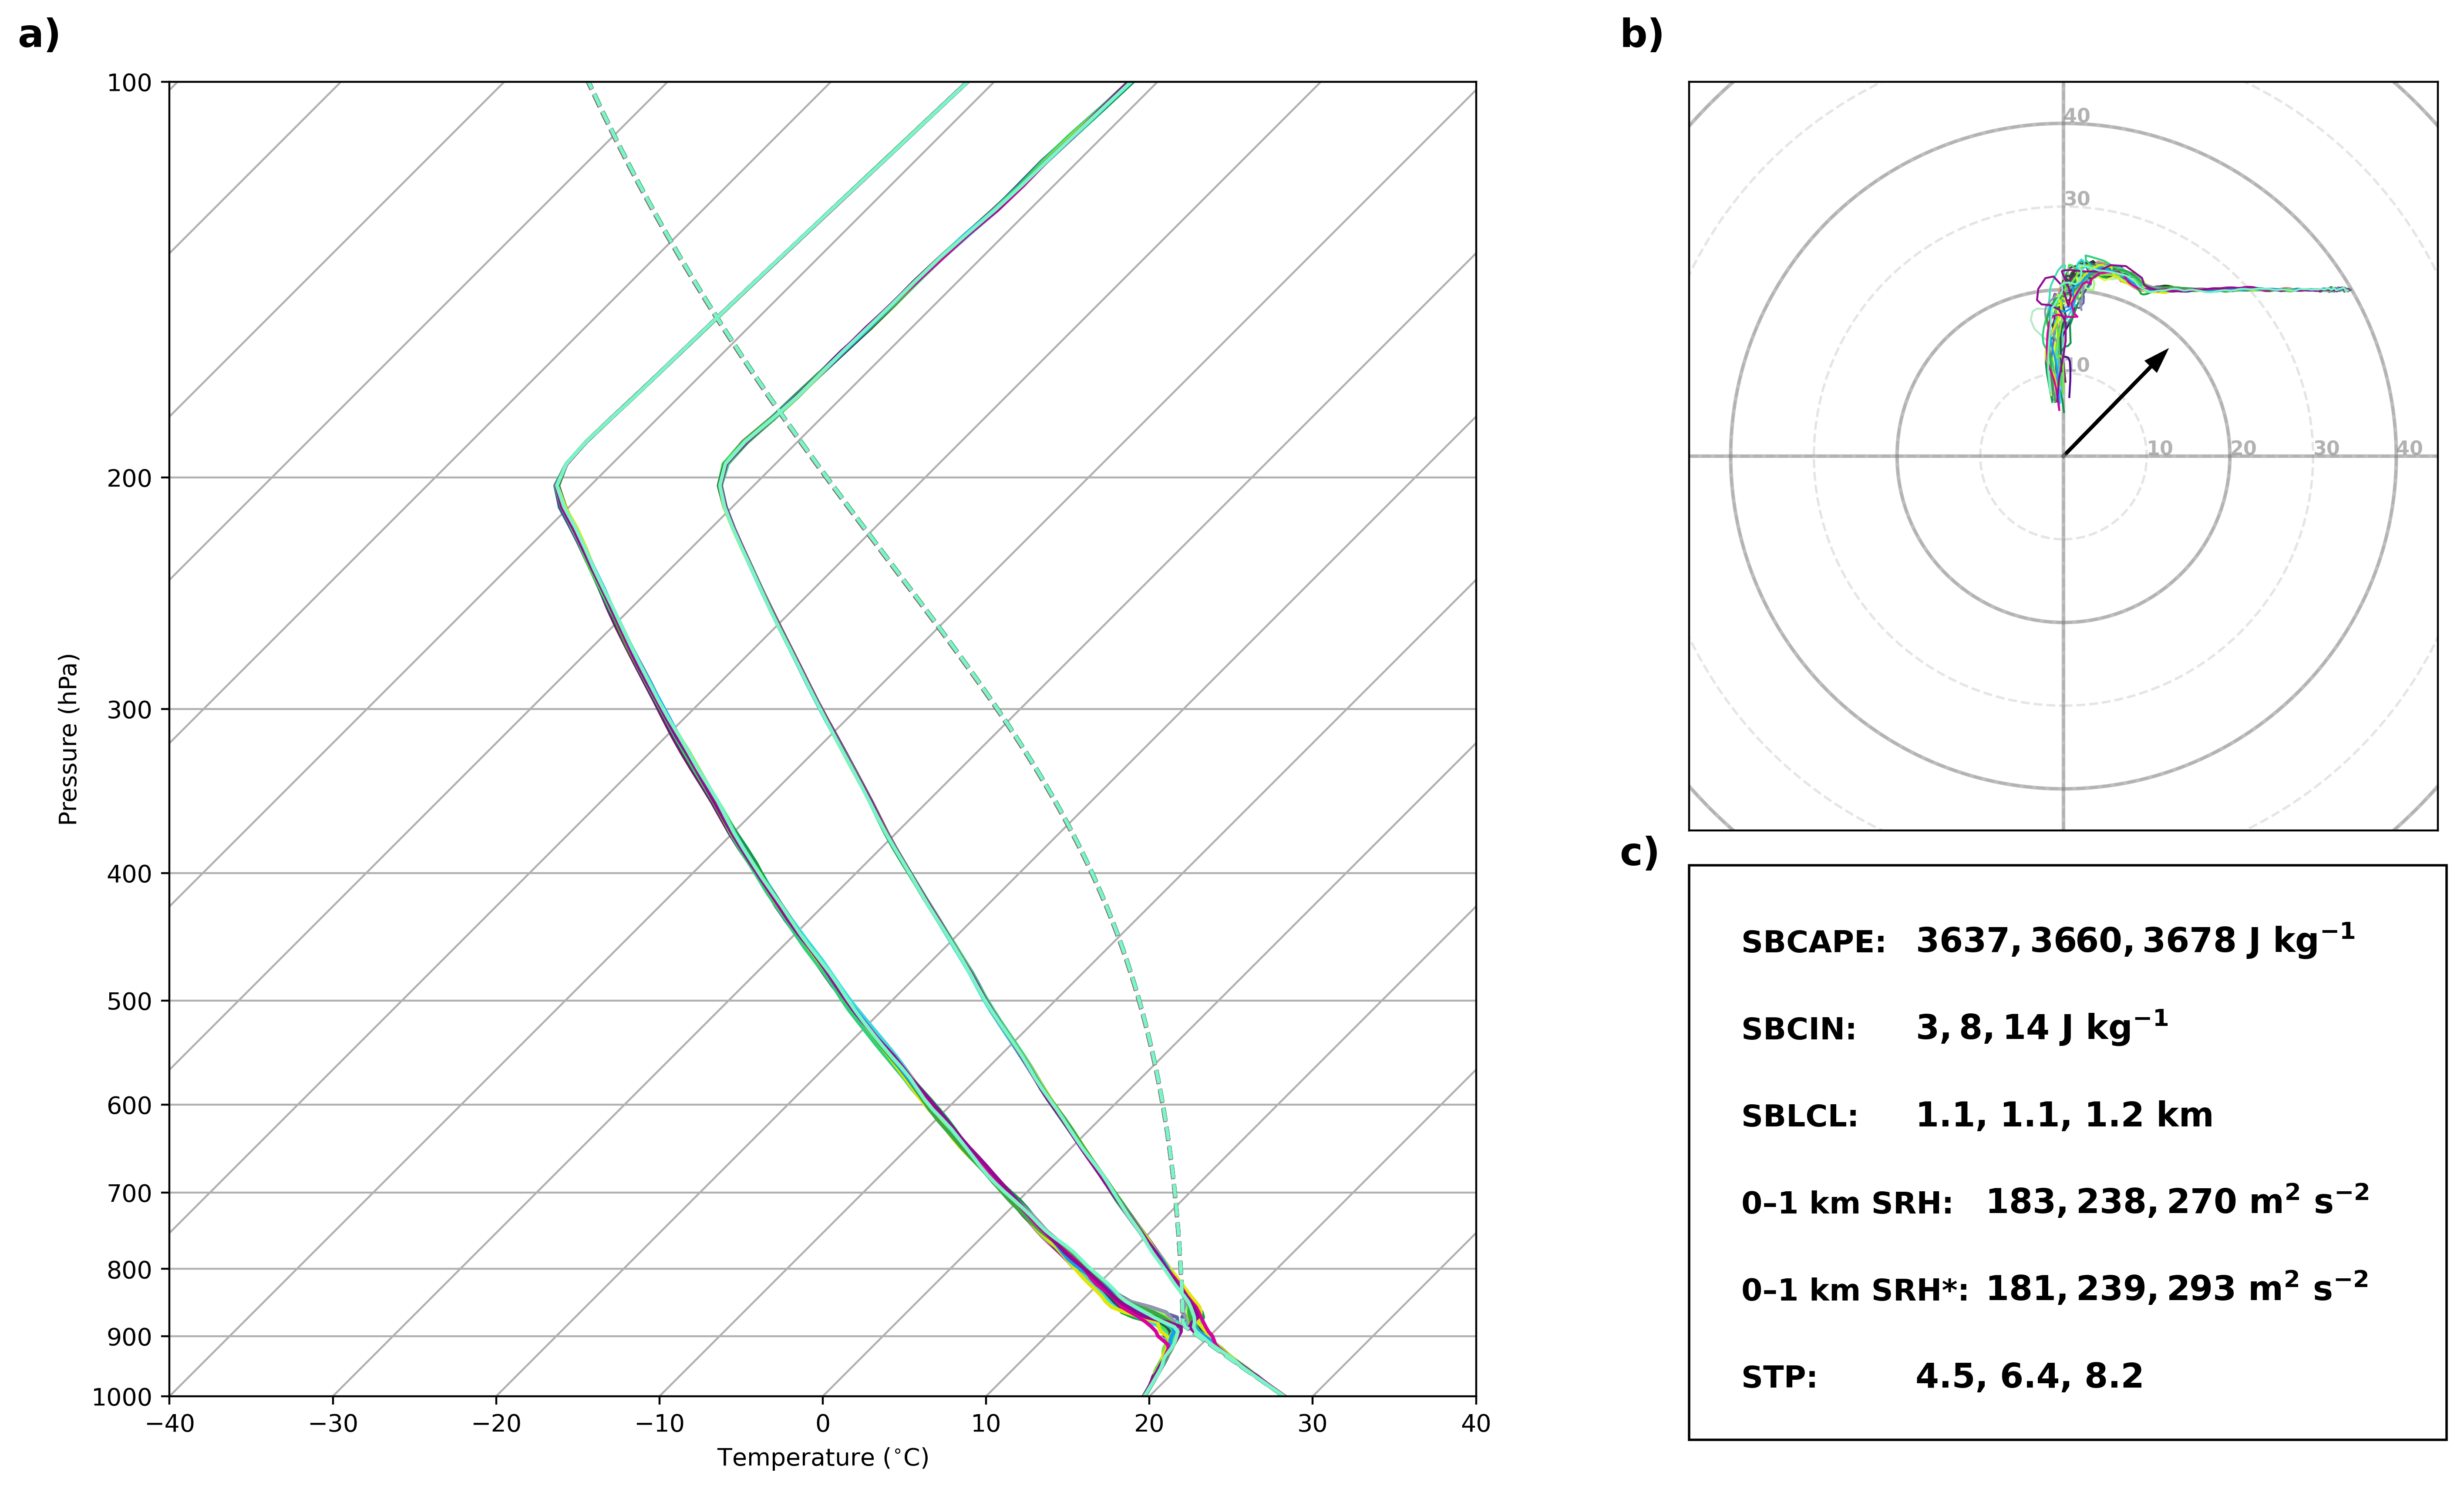

[4.73,
 5.53,
 7.13,
 6.07,
 6.87,
 5.38,
 6.29,
 6.95,
 6.63,
 6.69,
 4.95,
 7.35,
 7.07,
 7.54,
 6.25,
 7.33,
 7.15,
 5.62,
 6.71,
 6.89,
 5.72,
 4.52,
 5.46,
 6.33,
 6.26,
 6.03,
 6.87,
 8.2,
 6.83,
 5.79]

In [12]:
ensemble_skewT()

In [12]:
# This Cell Plots ALL Soundings for each simulation category 

# ASK IF SRH VALUES ARE TOO HIGH COMPARED TO ABOVE
# ASK ABOUT WRF vs METPY CAPE 
# METPY SEEMS TO UNDERESTIMATE 

# --------------------------------------------------------------------------------------------------------------

# Picks Random Color for each simulation
def rand_color():
    return [random.random(), random.random(), random.random(), 1.0];

# Picks Random Linestyle for each simulation
def rand_linestyle():
    linestyles = ['-', '--', '-.', ':']
    return random.choice(linestyles)

# --------------------------------------------------------------------------------------------------------------

# Function that plot all the SkewTs 
def skewT_plotter(sim_type, title_type):
    
    # Initialize SkewT Plot and set axis limits
    fig = plt.figure(figsize = (15,12))
    ax_hodograph = fig.add_axes([.82, 0.38, 0.5, 0.5])
    skew = SkewT(fig, rotation = 45)
    skew.ax.set_ylim(1000,100)
    skew.ax.set_xlim(-30,40)
    
    # Lists to append for Storm Predicting Parameters and Colors
    CAPE_list = []
    CIN_list = []
    SRH1km_list = []
    SRH1km_new_list = []
    #SRH3km_list = []
    color_list = []
    # Loop over all sims in a sim type and plot them 
    for x in tqdm(range(len(sim_type))):
        # Read in the respective simulation
        sim_data = xr.open_dataset(sim_paths[sim_type[x]] + 
                                   '/' + sim_names[0])[['prs', 'th', 'qv', 'uinterp', 'vinterp']].isel(time=0, yh = 0, xh =0)
        # Partition Variables
        P = sim_data['prs'].values*units('Pa')
        Th = sim_data['th'].values*units('degK')
        qv = sim_data['qv'].values*units('kg/kg')
        u = sim_data['uinterp'].values*units('m/s')
        v = sim_data['vinterp'].values*units('m/s')
        offset_u = 12.2*units('m/s')
        offset_v = 12.5*units('m/s')
        
        # Calculate Remaining Variables via metpy
        T = mpcalc.temperature_from_potential_temperature(P, Th)
        Td = mpcalc.dewpoint_from_specific_humidity(P, T, qv)
        parc_T = mpcalc.parcel_profile(P, T[0], Td[0])
        
        # Calculate Storm Predicting Parameters 
        CAPE, CIN = mpcalc.cape_cin(P, T, Td, parc_T)
        SRH1km = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                                u+offset_u, v+offset_v, bottom = 7.5*units('m'), 
                                                depth = 1*units('km'), storm_u = offset_u, storm_v = offset_v)[0]
        adjust_u, adjust_v = sm_adjusted(sim_paths[sim_type[x]], 12, 24)[0]
        SRH1km_new = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                                u+offset_u, v+offset_v, bottom = 7.5*units('m'), 
                                                depth = 1*units('km'), storm_u = adjust_u*units('m/s')
                                                    , storm_v = adjust_v*units('m/s'))[0]
        #SRH3km = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                                #u, v, bottom = 7.5*units('m'), 
                                                #depth = 3*units('km'), storm_u = offset_u, storm_v = offset_v)[0]
   
        
        # Plot SkewT for selected simulation
        color = rand_color()
        linestyle = rand_linestyle()
        skew.plot(P, T, color=color, linestyle = linestyle, label = f'{sim_type[x]+1}')
        skew.plot(P, Td, color = color, linestyle = linestyle)
        skew.plot(P , parc_T, color = color, linestyle = linestyle)
        
        # Cosmetic Touches
        skew.ax.set_xlabel('Temperature ($^{\circ}$C)')
        skew.ax.set_ylabel('Pressure (hPa)')
        
        # Initialize Hodograph
        h = metpy.plots.Hodograph(ax_hodograph, component_range = 40.)
        h.add_grid(increment = 5)
        
        # Plot Hodograph
        h.plot(u+offset_u, v + offset_v, color=color, linewidth = 1.5)
        
        # Save Parameters and Colors for text box at the end
        CAPE_list.append(round(CAPE.magnitude,2))
        CIN_list.append(round(CIN.magnitude,2))
        SRH1km_list.append(round(SRH1km.magnitude,2))
        SRH1km_new_list.append(round(SRH1km_new.magnitude,2))
        #SRH3km_list.append(round(SRH3km.magnitude,2))
        color_list.append(color)
    
    # Add Title and Legend
    skew.ax.set_title(f'{title_type} Soundings', fontsize=16)
    skew.ax.legend(fontsize=12)
    
    # Create A Textbox with all storm parameters
    params = [CAPE_list, CIN_list, SRH1km_list, SRH1km_new_list]
    colors = [color_list, color_list, color_list, color_list]

    # Textbox Axes
    ax_parameters = fig.add_axes([.73, .001, .2, .3])  # Smaller width for better fitting
    ax_parameters.set_xlim(0, 1)
    ax_parameters.set_ylim(0, 1)
    ax_parameters.axis("off")  # Hide axes

    # Define starting position **relative to ax_parameters**
    x_start, y_start = 0.5, 0.8  # Centered text starts at middle
    line_spacing = 0.15  # Adjust vertical spacing
    word_spacing = 0.4  # Increased for more spacing between values

    # Iterate through each group and add colored text
    param_names = ['CAPE', 'CIN', 'SRH1km', 'SRH1km$^{*}$']
    for i, (variables, color_group) in enumerate(zip(params, colors)):
        y_pos = y_start - i * line_spacing  # Move down for each group

        # Add the label (param name)
        ax_parameters.text(x_start, y_pos, f"{param_names[i]}:", fontsize=15, ha='center', color='black')

        # Adjust x_pos to give some space between the title and the first entry
        x_pos = x_start + 0.35  # Shift the first entry further to the right

        for var, color in zip(variables, color_group):
            ax_parameters.text(x_pos, y_pos, f"{var}", fontsize=15, ha='center', color=color)  # No brackets
            x_pos += word_spacing  # Increase space between values

    # Add rounded background box
    ax_parameters.text(0.5, -0.1, "", transform=ax_parameters.transAxes, ha='center', va='center',
                       bbox=dict(facecolor='#F0EAD6', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))


In [12]:
# Create Groups of Soundings Categorized by Weakly, Strongly, and Non-Tornadic

# Labels for each set of simulations
labels = list(sim_type.keys())

100%|██████████| 10/10 [03:47<00:00, 22.70s/it]


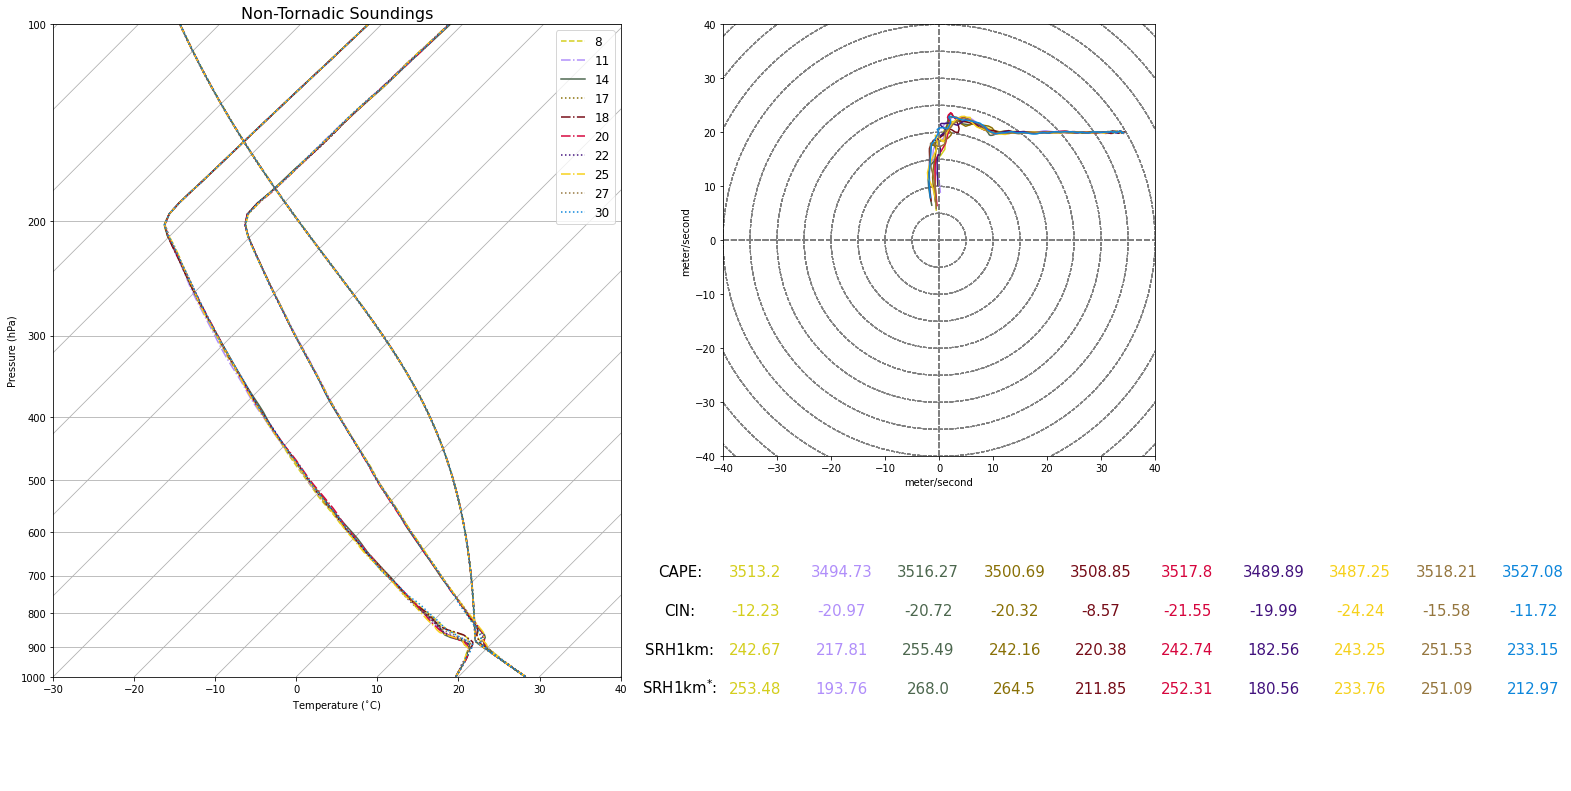

In [13]:
# Non-Tornadic
skewT_plotter(sim_type[labels[0]], labels[0])

# Create vertical boxplots of all parameters to show variability by sim type 

100%|██████████| 13/13 [04:58<00:00, 22.97s/it]


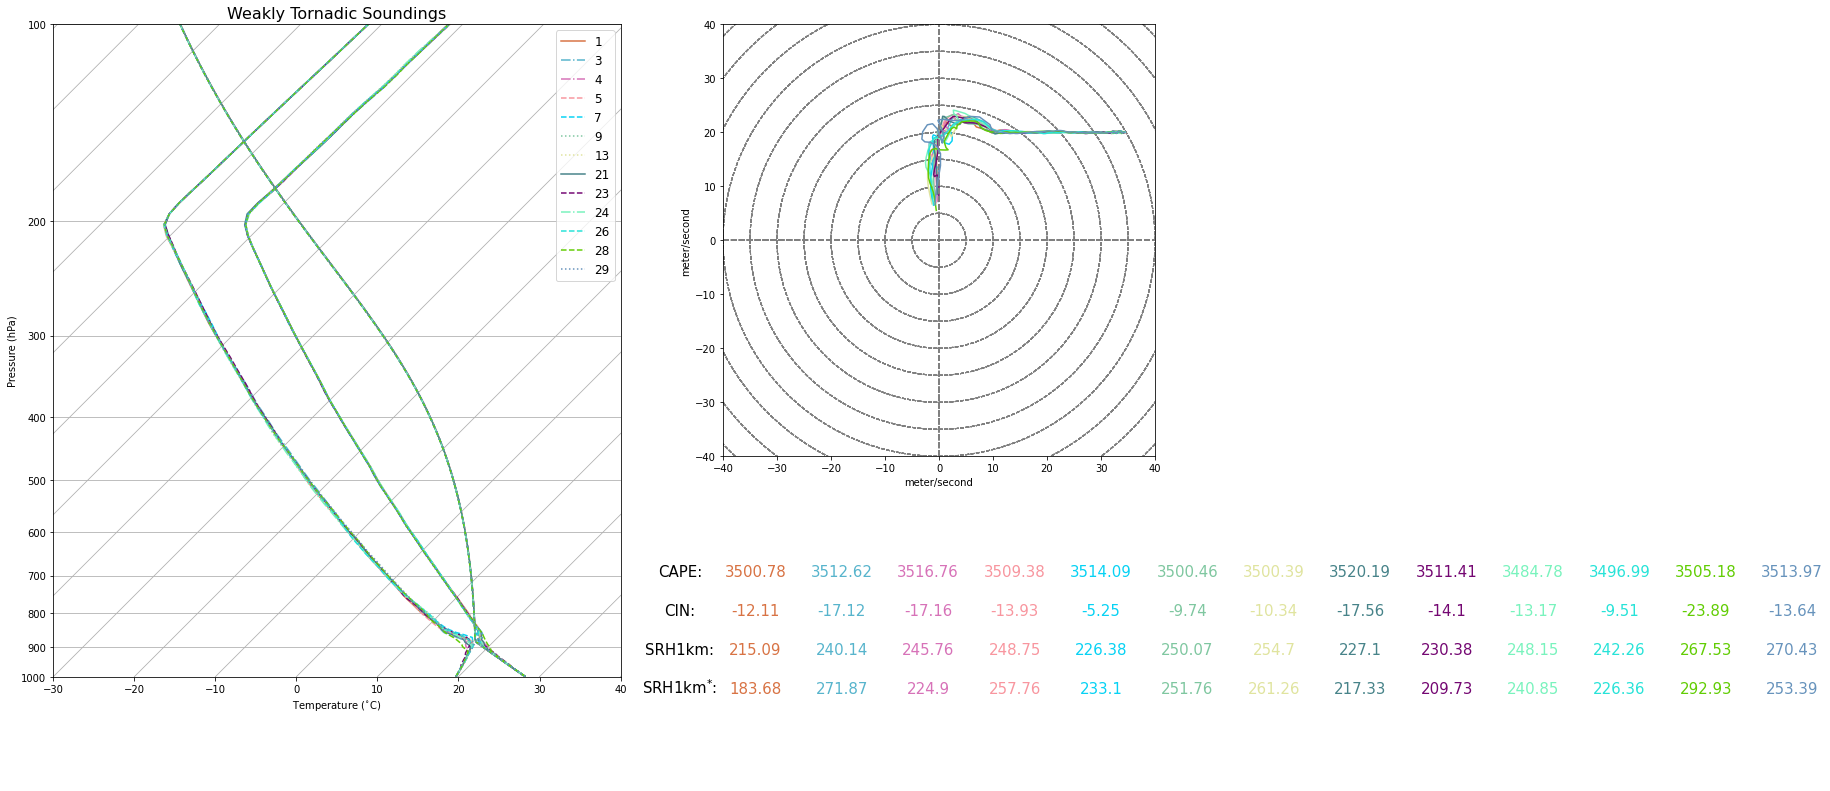

In [14]:
# Weakly Tornadic
skewT_plotter(sim_type[labels[1]], labels[1])

100%|██████████| 7/7 [02:37<00:00, 22.49s/it]


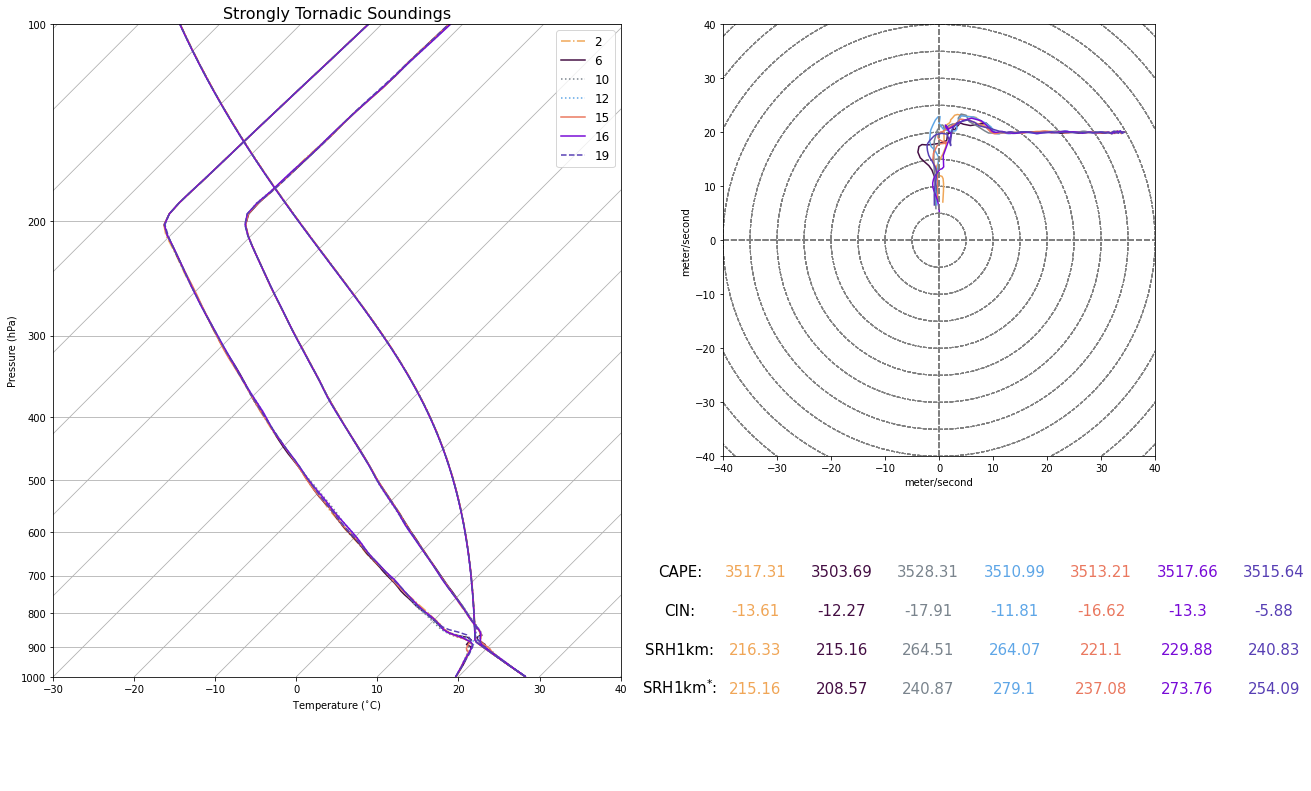

In [15]:
# Strongly Tornadic
skewT_plotter(sim_type[labels[2]], labels[2])

# Investigation of how differences in CIN might translate to hinderance of updraft speeds - Recommended by John

In [1]:
# Create a loop that computes the CAPE, CIN, and inferred updraft 
# speeds and hindrance by taking square roots of CAPE and CIN



# Different flavor: This Plot is the same as above, except it will include all simualtions together, with each category being a particular color.

In [1]:
# Create A Function that Creates the Plot
def ensemble_soundings(sim_type):
    
    # Initialize Figures
    fig = plt.figure(figsize=(14,10), dpi = 150)
    skew = SkewT(fig, rotation=45)
    ax_hodograph = fig.add_axes([.8, .25, .5,.5])
    skew.ax.set_ylim(1000,700)
    skew.ax.set_xlim(10,30)
    
    
    # Colors/labels Used For Plotting
    colors = ['blue', 'orange', 'red']
    labels = list(sim_type.keys())
    
    # Loop Over Each Simulation Category 
    for category in range(len(sim_type)): 
        # list of simulations for each category
        sims = sim_type[labels[category]]
        # Loop over all sims in each category
        for x in tqdm(range(len(sims))):
            # Read in simulation data
            sim_data = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[0])[['prs',
                                                                                 'th', 'qv', 'uinterp', 'vinterp']].isel(time=0, yh = 0, xh = 0)
            # Partition Variables
            P = sim_data['prs'].values*units('Pa')
            Th = sim_data['th'].values*units('degK')
            qv = sim_data['qv'].values*units('kg/kg')
            u = sim_data['uinterp'].values*units('m/s')
            v = sim_data['vinterp'].values*units('m/s')
            offset_u = 12.2*units('m/s')
            offset_v = 12.5*units('m/s')
        
            # Calculate Remaining Variables via metpy
            T = mpcalc.temperature_from_potential_temperature(P, Th)
            Td = mpcalc.dewpoint_from_specific_humidity(P, T, qv)
            parc_T = mpcalc.parcel_profile(P, T[0], Td[0])
            
            # Plot SkewT for selected simulation
            color = colors[category]
            linestyle = rand_linestyle()
            skew.plot(P, T, color=color, linestyle = linestyle)
            skew.plot(P, Td, color = color, linestyle = linestyle)
            skew.plot(P , parc_T, color = color, linestyle = linestyle)
        
            # Cosmetic Touches
            skew.ax.set_xlabel('Temperature ($^{\circ}$C)')
            skew.ax.set_ylabel('Pressure (hPa)')
        
            # Initialize Hodograph
            h = metpy.plots.Hodograph(ax_hodograph, component_range = 40.)
            h.add_grid(increment = 5)
        
            # Plot Hodograph
            h.plot(u+offset_u, v + offset_v, color=color, linewidth = 1.2)
            
    # Add Title and Legend
    #skew.ax.set_title(f'All Soundings')
    handles = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, labels)]
    skew.ax.legend(handles=handles)
    
        
        

100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


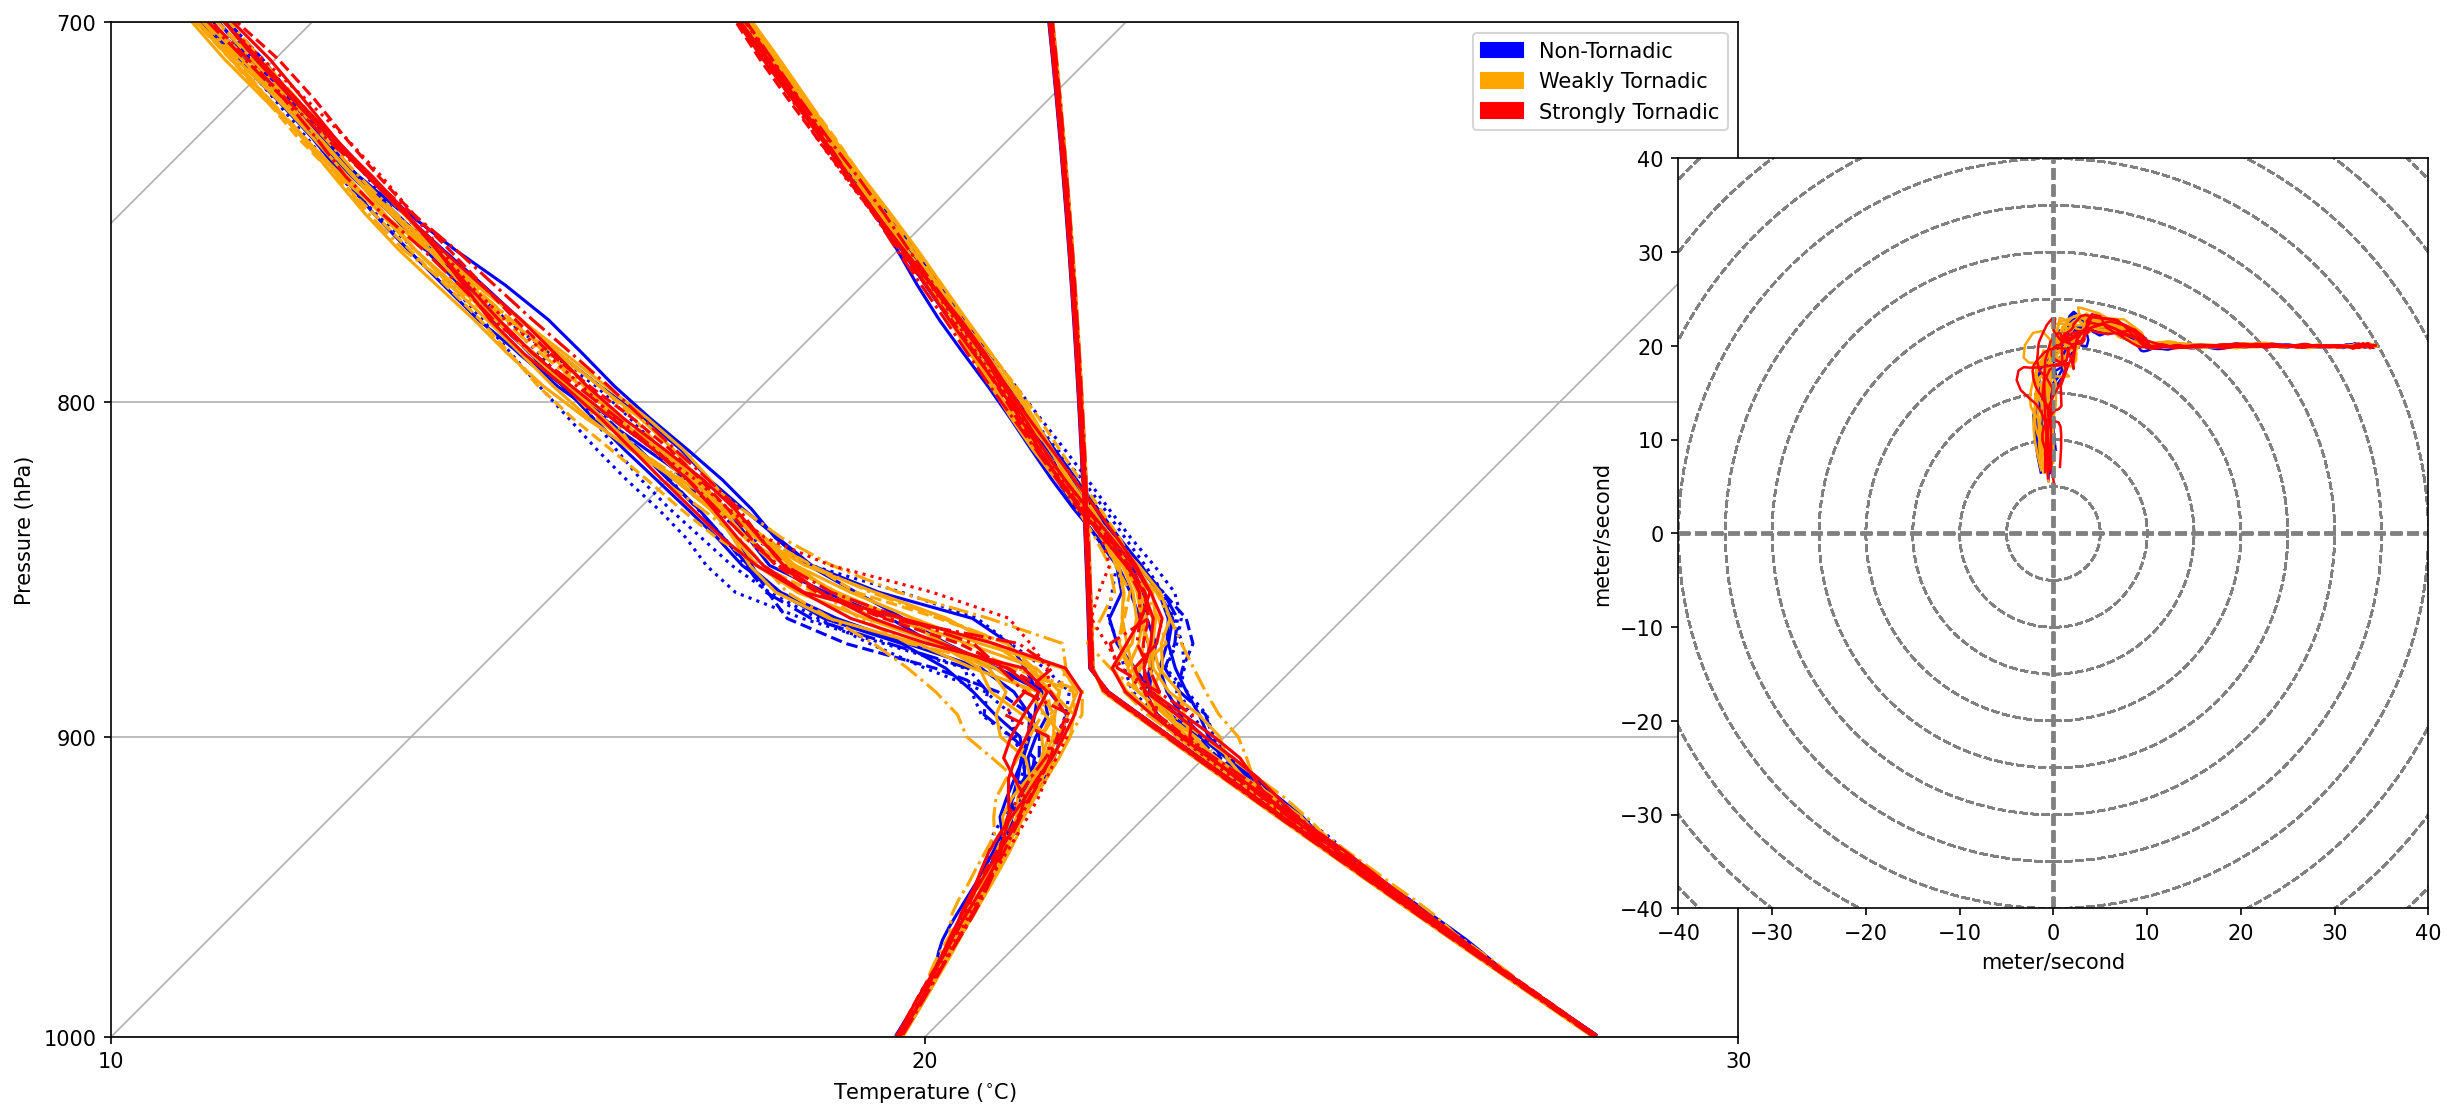

In [13]:
ensemble_soundings(sim_type)

# The following CODE creates different scatter plots testing to see if there are relationships between storm parameters and the maximum tornadic intensity.

In [18]:
# First Compute All Storm Predicting Parameters for Each Storm

# Create A Function that Automates this:
def comp_parameters(sim_path): 
    
    # Read in SIM Data at t = 0 to analyze the input sounding
    sim_data = xr.open_dataset(sim_path + '/' + sim_names[0])[['prs','th','qv','uinterp','vinterp']].isel(time=0, yh=0, xh=0)
    
    # Divy out the variables
    P = sim_data['prs'].values*units('Pa')
    Th = sim_data['th'].values*units('degK')
    qv = sim_data['qv'].values*units('kg/kg')
    u = sim_data['uinterp'].values*units('m/s')
    v = sim_data['vinterp'].values*units('m/s')
    offset_u = 12.2*units('m/s') # x-component of storm motion
    offset_v = 12.5*units('m/s') # y-component of storm motion
        
    # Calculate Remaining Variables via metpy
    T = mpcalc.temperature_from_potential_temperature(P, Th)
    Td = mpcalc.dewpoint_from_specific_humidity(P, T, qv)
    parc_T = mpcalc.parcel_profile(P, T[0], Td[0])
    
    # Calculate Storm Predicting Parameters 
    # (choosing to ignore SRH3km since 99% of SRH is confined to the 0-1km layer)
    CAPE, CIN = mpcalc.cape_cin(P, T, Td, parc_T)
    SRH1km = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                            u, v, bottom = 7.5*units('m'), 
                                            depth = 1*units('km'), storm_u = offset_u, storm_v = offset_v)[0]
    # Compute True SRH1km using the sm_adjust function
    adjust_u, adjust_v = sm_adjusted(sim_path, 12, 24)[0]
    true_SRH1km = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                            u, v, bottom = 7.5*units('m'), 
                                            depth = 1*units('km'), storm_u = adjust_u*units('m/s'), 
                                                 storm_v = adjust_v*units('m/s'))[0]
    
    # Return List of Parameters: [CAPE, CIN, SRH1km]
    return [CAPE.magnitude, CIN.magnitude, SRH1km.magnitude, true_SRH1km.magnitude];

In [19]:
# Create A Loop that utilizes the comp_parameters function

# initialize an empty dictionary object to store parameter data
storm_forecasting_parameters = {} 

# the loop 
for sim in tqdm(range(len(sim_paths))): 
    # compute parameters and save to dictionary
    storm_forecasting_parameters[run_names[sim]] = comp_parameters(sim_paths[sim])

100%|██████████| 28/28 [10:28<00:00, 22.46s/it]


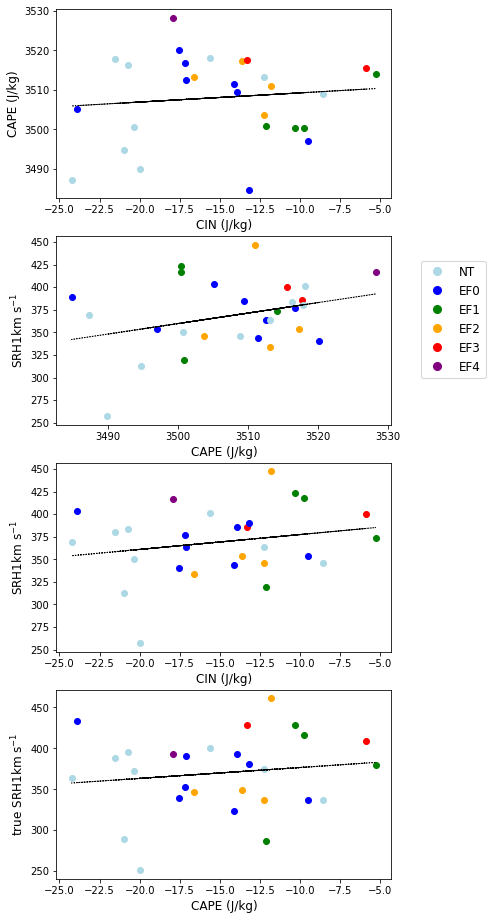

In [20]:
# Create Scatter Plots of different parameters compared with each other

# Plot Initialization
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(6,16))

# Colors and Labels
colors = {0: 'lightblue',
          1: 'blue',
          2: 'green',
          3: 'orange',
          4: 'red',
          5: 'purple'
}

labels = ['NT', 'EF0', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5']

# Plot Individual Correlation Plots (Order of Params is CAPE, CIN, SRH1km)
for x in range(len(sim_paths)):
    color = colors[hist_rating[x]]
    
    # Plot 1: CAPE vs. CIN
    axs[0].scatter(storm_forecasting_parameters[run_names[x]][1], storm_forecasting_parameters[run_names[x]][0], color = color)
    axs[0].set_xlabel('CIN (J/kg)', fontsize = 12)
    axs[0].set_ylabel('CAPE (J/kg)', fontsize = 12)
    
    # Plot 2: CAPE vs. SRH1km
    axs[1].scatter(storm_forecasting_parameters[run_names[x]][0], storm_forecasting_parameters[run_names[x]][2], color = color)
    axs[1].set_xlabel('CAPE (J/kg)', fontsize = 12)
    axs[1].set_ylabel('SRH1km m$^2$ s$^{-2}$$', fontsize = 12)
    
    # Plot 3: CIN vs. SRH1km
    axs[2].scatter(storm_forecasting_parameters[run_names[x]][1], storm_forecasting_parameters[run_names[x]][2], color = color)
    axs[2].set_xlabel('CIN (J/kg)', fontsize = 12)
    axs[2].set_ylabel('SRH1km m$^2$ s$^{-2}$', fontsize = 12)
    
    # Plot 3: CIN vs. true_SRH1km
    axs[3].scatter(storm_forecasting_parameters[run_names[x]][1], storm_forecasting_parameters[run_names[x]][3], color = color)
    axs[3].set_xlabel('CAPE (J/kg)', fontsize = 12)
    axs[3].set_ylabel('true SRH1km m$^2$ s$^{-2}$', fontsize = 12)
    
#Set Legend
legend_handles = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=f'{labels[rating]}')
    for rating, color in colors.items()
]
axs[1].legend(handles = legend_handles,fontsize = 12, bbox_to_anchor=[0.5, 0.5, 0.8, 0.4])

# Add Lines of Best Fit to each plot
CAPE = np.asarray([values[0] for key, values in storm_forecasting_parameters.items()])
CIN = np.asarray([values[1] for key, values in storm_forecasting_parameters.items()])
SRH1km = np.asarray([values[2] for key, values in storm_forecasting_parameters.items()])
true_SRH1km = np.asarray([values[3] for key, values in storm_forecasting_parameters.items()])

# Perform linear regression
m1, b1, r_1, p_1, std_err_1 = linregress(CIN, CAPE)
m2, b2, r_2, p_2, std_err_2 = linregress(CAPE, SRH1km)
m3, b3, r_3, p_3, std_err_3 = linregress(CIN, SRH1km)
m4, b4, r_4, p_4, std_err_4 = linregress(CIN, true_SRH1km)

# Plot Lines
axs[0].plot(CIN, m1*CIN + b1, linestyle='dotted',linewidth=1, color='k')
axs[1].plot(CAPE, m2*CAPE + b2, linestyle='dotted',linewidth=1, color='k')
axs[2].plot(CIN, m3*CIN+b3, linestyle='dotted',linewidth=1, color='k')
axs[3].plot(CIN, m4*CIN+b4, linestyle='dotted',linewidth=1, color='k')

In [23]:
print([r_1, r_2, r_3, r_4])

[0.1098194433935422, 0.31958156548014416, 0.21445879961765707, 0.14108421801694268]


# Create Plots that show the deviation in storm motion by each simulation
### Different Flavors 
### 1) Just Plot difference in average storm motion based on average deviation over last 1 hr of sim time 


The Following are the N-S levels being picked up on by each criteria
SIM8 - press: i:11.062500953674316, f:12.787500381469727
SIM8 - vort 5km: i:14.58750057220459, f:14.437500953674316
UH_i: 2529.753173828125, UH_f:10800.986328125
SIM8- w 2km: i:9.637500762939453, f:13.387500762939453


KeyboardInterrupt: 

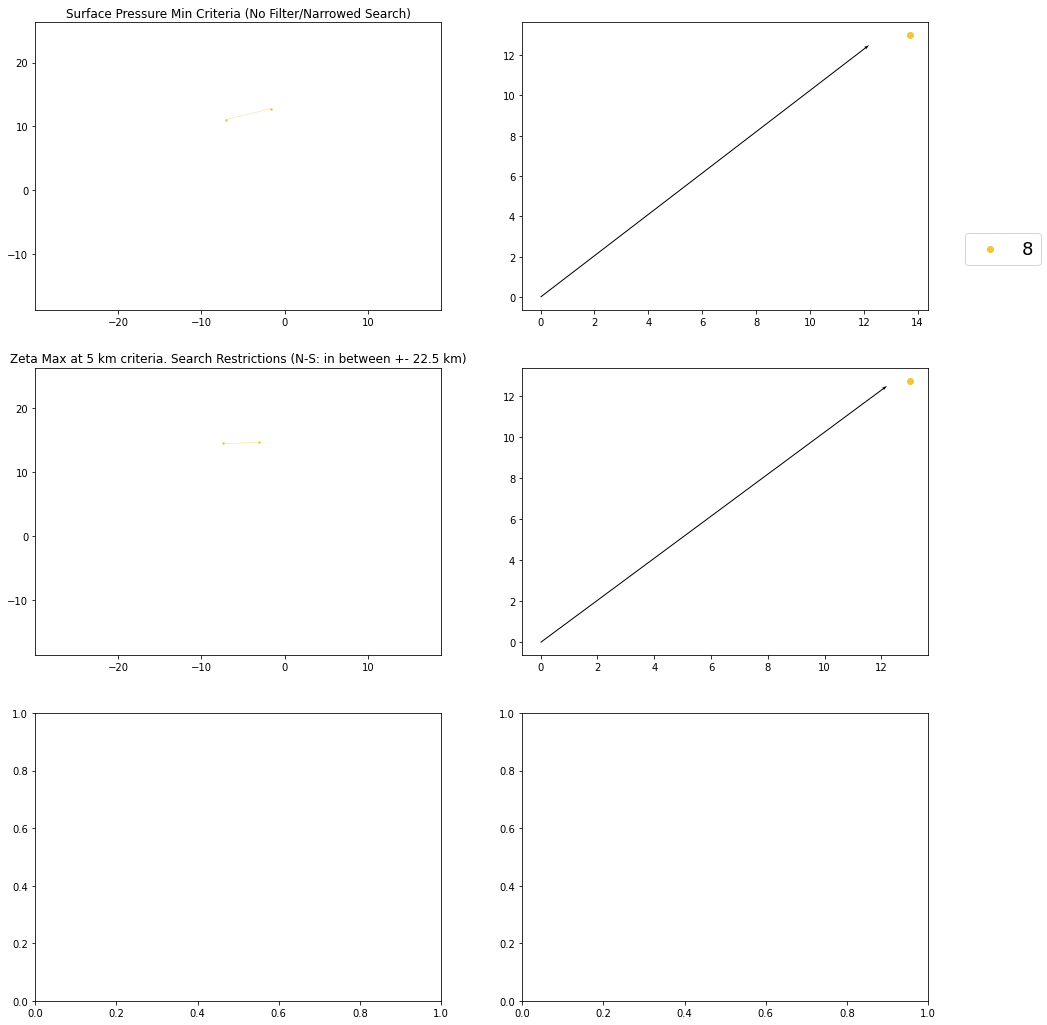

In [13]:
# TESTING EACH CRITERIA SCHEME TO DETERMINE THE BEST ONE FOR GENERAL STORM TRACKING

# UPDATE: Updraft at 2 km is the best  criteria for first guess of identifying storm/mesocyclone movement over time
# Need to remake all functions to generate plots before meeting with Paul 
# ADD Another column to the right to show how the mean motion changes for each criteria
z_2km = np.argmin(np.abs(z_data.values-2))
z_5km = np.argmin(np.abs(z_data.values -5))

fig, axs = plt.subplots(ncols=2, nrows = 3, figsize = (16,18))

print('The Following are the N-S levels being picked up on by each criteria')

for category in range(len(sim_type)): 
    sims = sim_type[labels[category]]
    for x in range(len(sims)):
        # Random color unique to each simulation across all the plots
        color = rand_color()
        
        # METHOD 1: Tracking Surface Pressure Minima
        press_i = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[12])['prs'].isel(time = 0, zh = 0)
        press_f = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[-1])['prs'].isel(time = 0, zh = 0)
        
        yh_i, xh_i = np.unravel_index(press_i.argmin(), press_i.shape)
        yh_f, xh_f = np.unravel_index(press_f.argmin(), press_f.shape)
        
        print(f'SIM{sims[x]+1} - press: i:{y_data.values[yh_i]}, f:{y_data.values[yh_f]}')
        
        # Compute Changes in Storm Motion
        u_adj = 12.2 + 1000*(x_data[xh_f] - x_data[xh_i])/3600
        v_adj = 12.5 + 1000*(y_data[yh_f] - y_data[yh_i])/3600
        
        # Plot Each Sims Adjusted Motion On Another Plot 
        start = np.array([0, 0])
        end = np.array([12.2, 12.5])
        dx, dy = end - start
        axs[0, 1].quiver(start[0], start[1], dx, dy, angles='xy', scale_units='xy', scale = 1, width = 0.0025, color = 'k')
        axs[0, 1].scatter(u_adj, v_adj, color = color, marker = 'o', linestyle='None')
        
        
        # Plot The Tracks
        axs[0, 0].plot([x_data[xh_i], x_data[xh_f]],[y_data[yh_i], y_data[yh_f]], marker = 'o', linestyle = '-',linewidth = 0.3, markersize=1.5, color= color)
        axs[0, 0].set_title('Surface Pressure Min Criteria (No Filter/Narrowed Search)')
        axs[0, 0].set_xlim(x_data.values[450], x_data.values[1100])
        axs[0, 0].set_ylim(y_data.values[600], y_data.values[1200])
        
       
        
        # ---------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # METHOD 2: Tracking Vorticity Maxima at z = 5km
        
        # STEP 1: First guess 
        zvort_i = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[12])['zvort'].isel(time = 0, zh = z_5km, yh = slice(550, 1125))
        zvort_f = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[-1])['zvort'].isel(time = 0, zh = z_5km, yh = slice(550, 1125))
        
        yh_i, xh_i = np.unravel_index(zvort_i.argmax(), zvort_i.shape)
        yh_f, xh_f = np.unravel_index(zvort_f.argmax(), zvort_f.shape)
        yh_i = yh_i + 550
        yh_f = yh_f + 550
        
        print(f'SIM{sims[x]+1} - vort 5km: i:{y_data.values[yh_i]}, f:{y_data.values[yh_f]}')
        
        # STEP 2: Use First Guess To Grab Vorticity and Vertical Velocity then compute UH
        zeta_i = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[12])['zvort'].isel(time = 0, zh = slice(z_2km, z_5km+1),
                                                                                        yh = slice(yh_i - 125, yh_i + 125),
                                                                                        xh = slice(xh_i - 125, xh_i + 125))
        zeta_f = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[-1])['zvort'].isel(time = 0, zh = slice(z_2km, z_5km +1),
                                                                                        yh = slice(yh_f - 125, yh_f + 125),
                                                                                        xh = slice(xh_f - 125, xh_f + 125))
        w_i = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[12])['winterp'].isel(time = 0, zh = slice(z_2km, z_5km+1),
                                                                                        yh = slice(yh_i - 125, yh_i + 125),
                                                                                        xh = slice(xh_i - 125, xh_i + 125))
        w_f = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[-1])['winterp'].isel(time = 0, zh = slice(z_2km, z_5km +1),
                                                                                        yh = slice(yh_f - 125, yh_f + 125),
                                                                                        xh = slice(xh_f - 125, xh_f + 125))
        # Loop to compute UH 
        UH_i = 0
        UH_f = 0
        dz = 1000*np.diff(z_data[z_2km: z_5km+1].values)
        for z in np.arange(0, z_5km - z_2km-1, 1):
            UH_i = UH_i + (1/4)*(zeta_i.isel(zh=z) + zeta_i.isel(zh = z+1))*(w_i.isel(zh=z) + w_i.isel(zh = z+1))*dz[z]
            UH_f = UH_f + (1/4)*(zeta_f.isel(zh=z) + zeta_f.isel(zh = z+1))*(w_f.isel(zh=z) + w_f.isel(zh = z+1))*dz[z]
        print(f'UH_i: {UH_i.max().values}, UH_f:{UH_f.max().values}')
        
        # STEP3: Find Max UH Value
        y_i, x_i = np.unravel_index(UH_i.argmax(), UH_i.shape)
        y_f, x_f = np.unravel_index(UH_f.argmax(), UH_f.shape)
        
        # Shift indices back to regular grid based off of original slice bounds
        x_i = x_i + (xh_i - 125)
        y_i = y_i + (yh_i - 125)
        x_f = x_f + (xh_f - 125)
        y_f = y_f + (yh_f - 125)
        
        # Plot the Locations
        axs[1, 0].plot([x_data[xh_i], x_data[xh_f]],[y_data[yh_i], y_data[yh_f]], marker = 'o', linestyle = '-',linewidth = 0.3, markersize=1.5, color= color)
        axs[1, 0].set_title('Zeta Max at 5 km criteria. Search Restrictions (N-S: in between +- 22.5 km)')
        axs[1, 0].set_xlim(x_data.values[450], x_data.values[1100])
        axs[1, 0].set_ylim(y_data.values[600], y_data.values[1200])
        
        # STEP4: Compute Adjusted Storm Motions and Plot
        u_adj = 12.2 + 1000*(x_data[x_f] - x_data[x_i])/3600
        v_adj = 12.5 + 1000*(y_data[y_f] - y_data[y_i])/3600
        
        # Plot Each Sims Adjusted Motion On Another Plot 
        start = np.array([0, 0])
        end = np.array([12.2, 12.5])
        dx, dy = end - start
        axs[1, 1].quiver(start[0], start[1], dx, dy, angles='xy', scale_units='xy', scale = 1, width = 0.0025, color = 'k')
        axs[1, 1].scatter(u_adj, v_adj, color = color, marker = 'o', linestyle='None', label = f'{sims[x]+1}')
        axs[1, 1].legend(bbox_to_anchor = (.8, 1, 0.5, 0.5), fontsize=18)
        
        
      
        # ---------------------------------------------------------------------------------------------------------------------------------------------------------------
       
        # METHOD 3: Tracking Vertical Velocity at z = 2 km
        winterp_i = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[12])['winterp'].isel(time = 0, zh = z_2km, yh = slice(550, 1125))
        winterp_f = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[-1])['winterp'].isel(time = 0, zh = z_2km, yh = slice(550, 1125))
        
        yh_i, xh_i = np.unravel_index(winterp_i.argmax(), winterp_i.shape)
        yh_f, xh_f = np.unravel_index(winterp_f.argmax(), winterp_f.shape)
        yh_i = yh_i + 550
        yh_f = yh_f + 550
        
        print(f'SIM{sims[x]+1}- w 2km: i:{y_data.values[yh_i]}, f:{y_data.values[yh_f]}')
        
        # STEP 2: Use First Guess To Grab Vorticity and Vertical Velocity then compute UH
        zeta_i = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[12])['zvort'].isel(time = 0, zh = slice(z_2km, z_5km+1),
                                                                                        yh = slice(yh_i - 125, yh_i + 125),
                                                                                        xh = slice(xh_i - 125, xh_i + 125))
        zeta_f = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[-1])['zvort'].isel(time = 0, zh = slice(z_2km, z_5km +1),
                                                                                        yh = slice(yh_f - 125, yh_f + 125),
                                                                                        xh = slice(xh_f - 125, xh_f + 125))
        w_i = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[12])['winterp'].isel(time = 0, zh = slice(z_2km, z_5km+1),
                                                                                        yh = slice(yh_i - 125, yh_i + 125),
                                                                                        xh = slice(xh_i - 125, xh_i + 125))
        w_f = xr.open_dataset(sim_paths[sims[x]] + '/' + sim_names[-1])['winterp'].isel(time = 0, zh = slice(z_2km, z_5km +1),
                                                                                        yh = slice(yh_f - 125, yh_f + 125),
                                                                                        xh = slice(xh_f - 125, xh_f + 125))
        # Loop to compute UH 
        UH_i = 0
        UH_f = 0
        dz = 1000*np.diff(z_data[z_2km: z_5km+1].values)
        for z in np.arange(0, z_5km - z_2km-1, 1):
            UH_i = UH_i + (1/4)*(zeta_i.isel(zh=z) + zeta_i.isel(zh = z+1))*(w_i.isel(zh=z) + w_i.isel(zh = z+1))*dz[z]
            UH_f = UH_f + (1/4)*(zeta_f.isel(zh=z) + zeta_f.isel(zh = z+1))*(w_f.isel(zh=z) + w_f.isel(zh = z+1))*dz[z]
        print(f'UH_i: {UH_i.max().values}, UH_f:{UH_f.max().values}')
        
        # STEP3: Find Max UH Value
        y_i, x_i = np.unravel_index(UH_i.argmax(), UH_i.shape)
        y_f, x_f = np.unravel_index(UH_f.argmax(), UH_f.shape)
        
        # Shift indices back to regular grid based off of original slice bounds
        x_i = x_i + (xh_i - 125)
        y_i = y_i + (yh_i - 125)
        x_f = x_f + (xh_f - 125)
        y_f = y_f + (yh_f - 125)
        
        # Plot the Locations
        axs[2, 0].plot([x_data[xh_i], x_data[xh_f]],[y_data[yh_i], y_data[yh_f]], marker = 'o', linestyle = '-',linewidth = 0.3, markersize=1.5, color= color)
        axs[2, 0].set_title('Vertical Velocity at 2 km criteria. Search Restrictions (N-S: in between +- 22.5 km)')
        axs[2, 0].set_xlim(x_data.values[450], x_data.values[1100])
        axs[2, 0].set_ylim(y_data.values[600], y_data.values[1200])
        
        # STEP4: Compute Adjusted Storm Motions and Plot
        u_adj = 12.2 + 1000*(x_data[x_f] - x_data[x_i])/3600
        v_adj = 12.5 + 1000*(y_data[y_f] - y_data[y_i])/3600
        
        # Plot Each Sims Adjusted Motion On Another Plot 
        start = np.array([0, 0])
        end = np.array([12.2, 12.5])
        dx, dy = end - start
        axs[2, 1].quiver(start[0], start[1], dx, dy, angles='xy', scale_units='xy', scale = 1, width = 0.0025, color = 'k')
        axs[2, 1].scatter(u_adj, v_adj, color = color, marker = 'o', linestyle='None') 
        print('---------------------------------------------')
        
    

In [14]:
# Create A Function That Tracks General Storm Motion

# Criteria: First guess at updraft location is locating the updraft velocity maxima at z = 2km at t1 & t2

# Additional Search: Compute UH (2 - 5 km) in approximately a 18 km by 18 km box surrounding the first guess at each analysis time
# and find the UH maxima at each time 

# Compute adjusted storm motion by adding observed motion of storm in CM1 grid (input 
# soundings have original storm motion , (12.2, 12.5), subtracted off so any additional 
# motion observed is deviations from this mean value)

def sm_adjusted(sim_path, t1, t2):
    # Height index Corresponding to z = 2 km
    z_2km = np.argmin(np.abs(z_data.values-2))
    z_5km = np.argmin(np.abs(z_data.values -5))
    
    # STEP1: Find approximate locations using first guess: restrict search to yh = +- 22.5 km to avoid picking up on the LM supercell
    
    # Read in Vertical Velocity 
    winterp_i = xr.open_dataset(sim_path + '/' + sim_names[t1])['winterp'].isel(time = 0, zh = z_2km, yh = slice(550, 1125))
    winterp_f = xr.open_dataset(sim_path + '/' + sim_names[t2])['winterp'].isel(time = 0, zh = z_2km, yh = slice(550, 1125))
    # Find Velocity Maxima (adjust yh indices back to original grid since we took a slice, and the current yh index is relative to that slice)
    yh_i, xh_i = np.unravel_index(winterp_i.argmax(), winterp_i.shape)
    yh_f, xh_f = np.unravel_index(winterp_f.argmax(), winterp_f.shape)
    yh_i = yh_i + 550
    yh_f = yh_f + 550
    
    # STEP2: Use First Guess to grab vorticity and vertical velocity clouds to compute UH
    
    # Zeta
    zeta_i = xr.open_dataset(sim_path + '/' + sim_names[t1])['zvort'].isel(time = 0, zh = slice(z_2km, z_5km+1),
                                                                           yh = slice(yh_i - 125, yh_i + 125),
                                                                           xh = slice(xh_i - 125, xh_i + 125))
    zeta_f = xr.open_dataset(sim_path + '/' + sim_names[t2])['zvort'].isel(time = 0, zh = slice(z_2km, z_5km+1),
                                                                           yh = slice(yh_f - 125, yh_f + 125),
                                                                           xh = slice(xh_f - 125, xh_f + 125))
    # Vertical Velocity
    w_i = xr.open_dataset(sim_path + '/' + sim_names[t1])['winterp'].isel(time = 0, zh = slice(z_2km, z_5km+1),
                                                                           yh = slice(yh_i - 125, yh_i + 125),
                                                                           xh = slice(xh_i - 125, xh_i + 125))
    w_f = xr.open_dataset(sim_path + '/' + sim_names[t2])['winterp'].isel(time = 0, zh = slice(z_2km, z_5km+1),
                                                                           yh = slice(yh_f - 125, yh_f + 125),
                                                                           xh = slice(xh_f - 125, xh_f + 125))
    # STEP 3: Compute 2-5 km UH
    
    # Start summation at 0 and determine spacing between height levels
    UH_i = 0
    UH_f = 0
    dz = 1000*np.diff(z_data[z_2km: z_5km+1].values)
    # Loop to compute UH    
    for z in np.arange(0, z_5km - z_2km-1, 1):
        UH_i = UH_i + (1/4)*(zeta_i.isel(zh=z).values + zeta_i.isel(zh = z+1)).values*(w_i.isel(zh=z).values 
                                                                                       + w_i.isel(zh = z+1).values)*dz[z]
        UH_f = UH_f + (1/4)*(zeta_f.isel(zh=z).values + zeta_f.isel(zh = z+1)).values*(w_f.isel(zh=z).values
                                                                                       + w_f.isel(zh = z+1).values)*dz[z]
        
    # STEP 4: Find UH Maxima 
    y_i, x_i = np.unravel_index(UH_i.argmax(), UH_i.shape)
    y_f, x_f = np.unravel_index(UH_f.argmax(), UH_f.shape)
        
    # Shift indices back to regular grid based off of original slice bounds
    x_i = x_i + (xh_i - 125)
    y_i = y_i + (yh_i - 125)
    x_f = x_f + (xh_f - 125)
    y_f = y_f + (yh_f - 125)
    
    # STEP 5: Compute New Storm Motion
    
    # Original Storm Motion (m/s)
    mean_u = 12.2 
    mean_v = 12.5
    
    # New Storm Motion
    u_adj = mean_u + 1000*(x_data[x_f] - x_data[x_i]).values/(300*(t2-t1))
    v_adj = mean_v + 1000*(y_data[y_f] - y_data[y_i]).values/(300*(t2-t1))
        
    # FINAL STEP: Return the Storm Locations and Adjusted Storm Motion
    # Format: (u, v), (y_i, x_i), (y_f, x_f)
    return [(u_adj, v_adj), (y_i, x_i), (y_f, x_f)];
        

100%|██████████| 7/7 [01:26<00:00, 12.41s/it]


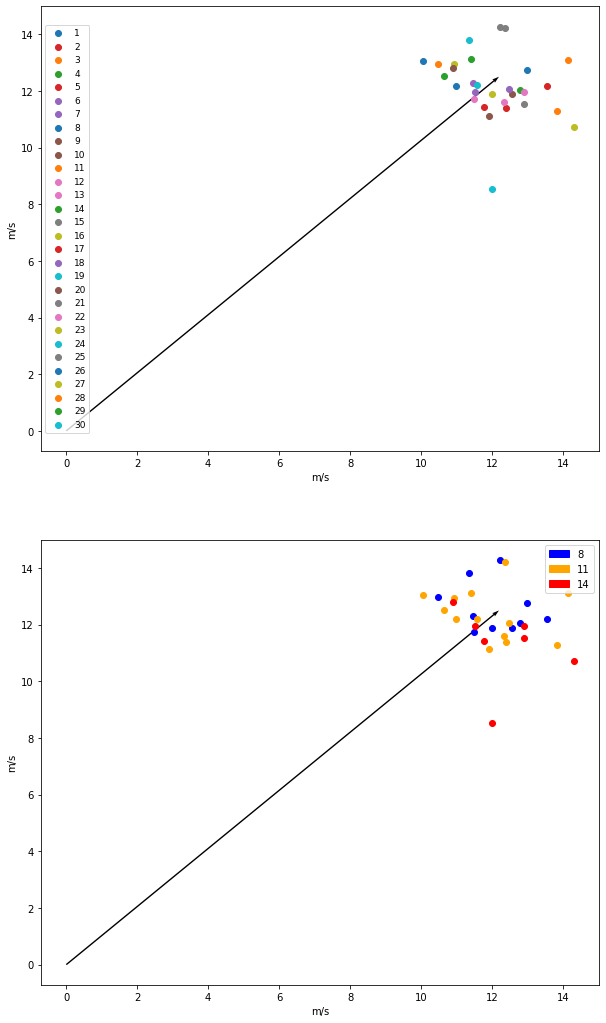

In [98]:
# Compute the Change in The Mean Storm Motion Vector Over the last hour

# Initialize Figure
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,18))

# t = 1hr and 2hr indices
t1 = 12
t2 = 24

# Plot the original motion as a black line
start = np.array([0, 0])
end = np.array([12.2, 12.5])
dx, dy = end - start
axs[0].quiver(start[0], start[1], dx, dy, angles='xy', scale_units='xy', scale=1, width = 0.0025, color='k')
axs[1].quiver(start[0], start[1], dx, dy, angles='xy', scale_units='xy', scale=1, width = 0.0025, color='k')

# Colors/labels Used For Plotting
colors = ['blue', 'orange', 'red']
labels = list(sim_type.keys())
    
# Loop Over Each Simulation Category 
for category in range(len(sim_type)): 
    # list of simulations for each category
    sims = sim_type[labels[category]]
    # Loop over all sims in each category
    for x in tqdm(range(len(sims))):
        u, v = sm_adjusted(sim_paths[sims[x]], t1, t2)[0]
        
        # FLAVOR 1: Uniquely Label Each Storm
        
        # Choose Random Color
        axs[0].scatter(u, v, marker = 'o', linestyle='None', label = f'{sims[x]+1}')
        
        # FLAVOR 2: Label as NT, WT, ST
        axs[1].scatter(u, v, color = colors[category], marker = 'o', linestyle='None')
        
#Cosmetics
# Sorting legend labels
handles, labels = axs[0].get_legend_handles_labels()

# Sort labels and reorder handles accordingly
sorted_pairs = sorted(zip(map(int, labels), handles))  # Convert labels to int for sorting
sorted_labels, sorted_handles = zip(*sorted_pairs)  # Unzip sorted pairs

# Apply sorted legend
axs[0].legend(sorted_handles, [str(label) for label in sorted_labels], fontsize=9,  loc = 'center left')


# Top Plot
axs[0].set_ylabel('m/s')
axs[0].set_xlabel('m/s')
#axs[0].legend(loc = 'center left')

# Bottom Plot
axs[1].set_ylabel('m/s')
axs[1].set_xlabel('m/s')
handles = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, labels)]
axs[1].legend(handles=handles)
# -------------------------------------------------------------------------------------------------------------------------





In [92]:
sim_type

{'Non-Tornadic': array([ 7, 10, 13, 16, 17, 19, 21, 24, 26, 29]),
 'Weakly Tornadic': array([ 0,  2,  3,  4,  6,  8, 12, 20, 22, 23, 25, 27, 28]),
 'Strongly Tornadic': array([ 1,  5,  9, 11, 14, 15, 18])}

In [16]:
# Create A Function that computes the true storm motion 
# (accounts for the deviation from the average  storm motion from the parent environment 
# by roughly computing the additional observed motion over the last hour of each simulation - using surface pressure minima)

def sm_adjust_pressmin(sim_path, t1, t2):
    
    # Average Storm Motion from parent storm environment
    mean_u = 12.2
    mean_v = 12.5
    
    # Read in pressure data at t = 1 & 2 hrs 
    pres_i = xr.open_dataset(sim_path + '/' + sim_names[t1])['prs'].isel(time=0, zh =0)
    pres_f = xr.open_dataset(sim_path + '/' + sim_names[t2])['prs'].isel(time=0, zh =0)
    
    # Find the indices of minimum pressure to track the updraft center (approximate storm) propogation
    ind_i = np.unravel_index(pres_i.argmin(), pres_i.shape) # t = 1 hr
    ind_f = np.unravel_index(pres_f.argmin(), pres_f.shape) # t = 2 hr
    
    # Compute the Additional Observed Storm Motion (m/s)
    obs_u = 1000*(x_data[ind_f[-1]] - x_data[ind_i[-1]]).values/3600
    obs_v = 1000*(y_data[ind_f[0]] - y_data[ind_i[0]]).values/3600
    
    # Compute adjusted storm motion
    adjust_u = mean_u + obs_u
    adjust_v = mean_v + obs_v
    
    # Return Adjusted Storm Motion and also the indices of pressure minimums
    return ((adjust_u, adjust_v), (ind_f, ind_i));

100%|██████████| 7/7 [00:01<00:00,  3.96it/s]


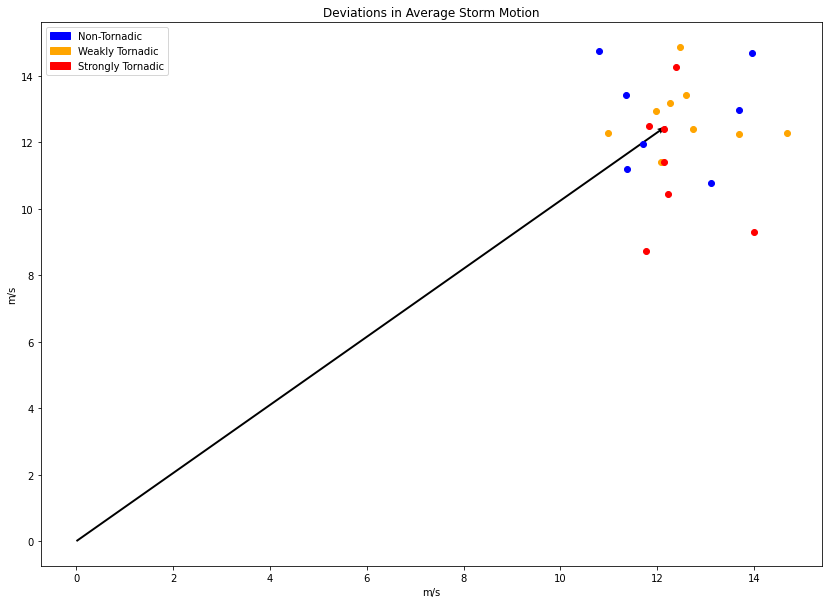

In [15]:
# NEVER Re-Run this cell: This is the results from the minimum surface pressure tracking 
deviations_1hr(sim_type)

### 2) Same as 1) except plot deviations at every 5 minute interval and label depending on whether a tornado was occuring at the time or just prior

In [17]:
# Uses def sm_adjustment function above

# Create a function that determines if the next 5 minutes at a given time are tornadic
def TLV_check(run_name, i):
    # Index For TLV_tracker object
    ind = i*10
    
    # Blue for non-tornadic, Red for tornadic
    colors = ['red', 'blue']
    
    # Check if the next 5 minutes are tornadic
    if TLV_tracker[run_name][ind: ind+11].any() != 0:
        color = colors[0]
    else: 
        color = colors[1]
    
    # return color for plotting
    return color;
    

In [18]:
# Calculate Adjusted Storm Motions At Each Timestep Starting at 1-hour
# Also find out if simulations are tornadic at any point within the upcoming 5 minutes
storm_motions = {}
for y in tqdm(np.arange(0, len(sim_paths),1)):
    velocities = []
    colors = []
    for x in tqdm(np.arange(12, len(sim_names)-1, 1)):
        u, v = sm_adjusted(sim_paths[y], x, x+1)[0]
        color = TLV_check(run_names[y], x)
        velocities.append([u ,v])
        colors.append(color)
    storm_motions[run_names[y]] = [velocities, colors]

 50%|█████     | 6/12 [00:53<00:51,  8.54s/it]


100%|██████████| 30/30 [53:29<00:00, 107.00s/it]


In [19]:
# Save the storm_motions dictionary so I don't have to re-run the cell above

path = '/storage/work/bsh5393/Masters Thesis/Pre-Storm Environment Soundings/Data/'
with open(path + 'storm_motions.pkl', 'wb') as f:
    pickle.dump(storm_motions, f)

In [14]:
# Open The Storm Motions Dataset
path = '/storage/work/bsh5393/Masters Thesis/Pre-Storm Environment Soundings/Data/'
with open(path + 'storm_motions.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

100%|██████████| 30/30 [00:00<00:00, 33.58it/s]


Text(0, 0.5, 'm/s')

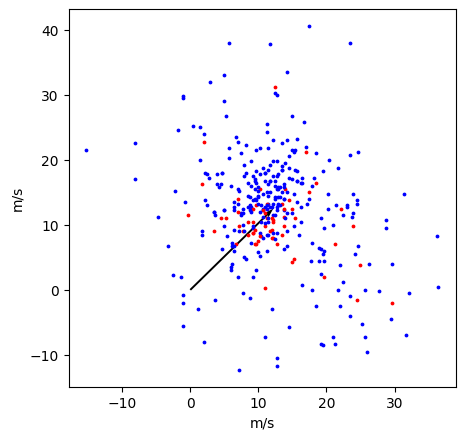

In [19]:
# Make A Scatter Plot of this data 
fig = plt.figure(figsize=(5,5), dpi = 100)
# Plot Average Storm Motion as a Black Line
start = np.array([0, 0])
end = np.array([12.2, 12.5])
dx, dy = end - start
plt.quiver(start[0], start[1], dx, dy, angles='xy', scale_units='xy', scale=1,width = 0.005, color='k')

for x in tqdm(range(len(run_names))):
    for y in np.arange(0, 12, 1):
        plt.scatter(loaded_data[run_names[x]][0][y][0], loaded_data[run_names[x]][0][y][1], 
                    color = loaded_data[run_names[x]][1][y], s=3)
    
#plt.xlim(0,30)    
#plt.ylim(0,30)
#plt.title('Observed Storm Motions (5 min. intervals)')
plt.xlabel('m/s')
plt.ylabel('m/s')

100%|██████████| 30/30 [00:00<00:00, 33.17it/s]


Text(0, 0.5, 'm/s')

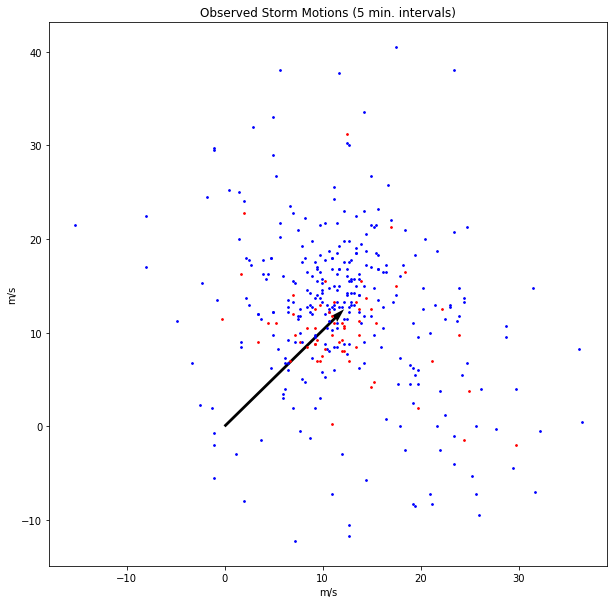

In [81]:
# Make A Scatter Plot of this data 
fig = plt.figure(figsize=(10,10))
# Plot Average Storm Motion as a Black Line
start = np.array([0, 0])
end = np.array([12.2, 12.5])
dx, dy = end - start
plt.quiver(start[0], start[1], dx, dy, angles='xy', scale_units='xy', scale=1,width = 0.005, color='k')

for x in tqdm(range(len(run_names))):
    for y in np.arange(0, 12, 1):
        plt.scatter(loaded_data[run_names[x]][0][y][0], loaded_data[run_names[x]][0][y][1], 
                    color = loaded_data[run_names[x]][1][y], s=3)
    
#plt.xlim(0,30)    
#plt.ylim(0,30)
plt.title('Observed Storm Motions (5 min. intervals)')
plt.xlabel('m/s')
plt.ylabel('m/s')

Text(0.5, 0.93, 'Kernel Density Estimation of Observed Storm Motions\n (All Ensemble Members: ${\\Delta}$t = 5 min)')

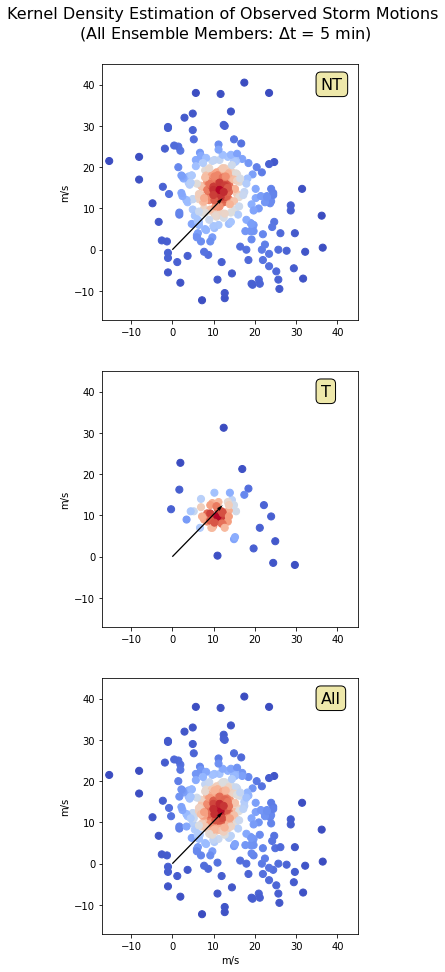

In [82]:
# Look into kernel density estimation

# Break into 3 Plots: Non-Tornadic, Tornadic, and All Together

# Create Storage Arrays For Each Plot
NT_u = []
NT_v = []
T_u = []
T_v = []
All_u = []
All_v = []

# Loop over each simulation's values, using the saved color as the discriminator
for sim in range(len(run_names)):
    for x in range(len(loaded_data[run_names[sim]][0])):
        # Read in Velocity/Color For Each Time per sim 
        u, v = loaded_data[run_names[sim]][0][x]
        color = loaded_data[run_names[sim]][1][x]
        
        # Save all velocities 
        All_u.append(u)
        All_v.append(v)
        
        # Parse into Tornadic vs. Non-Tornadic
        # Tornadic
        if color == 'red':
            T_u.append(u)
            T_v.append(v)
        # Non-Tornadic
        if color == 'blue':
            NT_u.append(u)
            NT_v.append(v)

# Convert to Arrays
NT_u = np.asarray(NT_u)
NT_v = np.asarray(NT_v)
T_u = np.asarray(T_u)
T_v = np.asarray(T_v)
All_u = np.asarray(All_u)
All_v = np.asarray(All_v)

# Create the 3 Plots 
fig, axs = plt.subplots(ncols = 1, nrows =3, figsize = (8,16))

# Perform KDE on each subset of velocities and plot

# Top Plot: Non-Tornadic
NonTor = np.vstack([NT_u, NT_v])
NT_KDE = gaussian_kde(NonTor)(NonTor)
axs[0].scatter(NT_u, NT_v, c= NT_KDE, cmap='coolwarm', s = 50)
axs[0].set_xlim(-17, 45)
axs[0].set_ylim(-17, 45)
axs[0].text(36, 39, 'NT', fontsize=16,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))
axs[0].set_ylabel('m/s')
axs[0].set_aspect('equal')

# Middle: Tornadic
Tor = np.vstack([T_u, T_v])
T_KDE = gaussian_kde(Tor)(Tor)
axs[1].scatter(T_u, T_v, c = T_KDE, cmap='coolwarm', s = 50)
axs[1].set_xlim(-17, 45)
axs[1].set_ylim(-17, 45)
axs[1].text(36, 39, 'T', fontsize=16,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))
axs[1].set_ylabel('m/s')
axs[1].set_aspect('equal')



# Bottom: All Data
All = np.vstack([All_u, All_v])
All_KDE = gaussian_kde(All)(All)
axs[2].scatter(All_u, All_v, c = All_KDE, cmap='coolwarm', s = 50)
axs[2].set_xlim(-17, 45)
axs[2].set_ylim(-17, 45)
axs[2].text(36, 39, 'All', fontsize=16,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))
axs[2].set_ylabel('m/s')
axs[2].set_xlabel('m/s')
axs[2].set_aspect('equal')

# Plot the Mean Storm Motion Vector on Each Plot
start = np.array([0, 0])
end = np.array([12.2, 12.5])
dx, dy = end - start 
for x in range(3):
    axs[x].quiver(start[0], start[1], dx, dy, angles='xy', scale_units='xy', scale=1,width = 0.005, color='k' )
    
# Title
plt.suptitle('Kernel Density Estimation of Observed Storm Motions\n (All Ensemble Members: ${\Delta}$t = 5 min)', fontsize = 16, 
             y = .93)


Text(0.5, 0.93, 'Kernel Density Estimation of Observed Storm Motions\n (All Ensemble Members: ${\\Delta}$t = 5 min)')

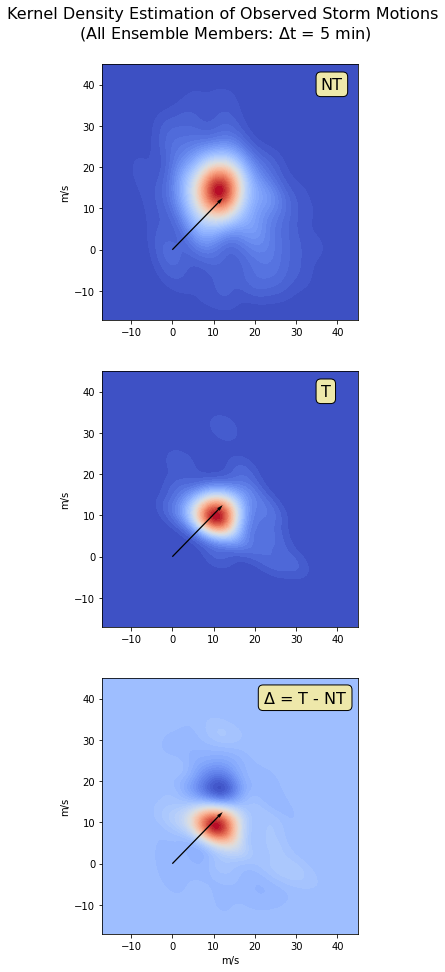

In [83]:
# Look into kernel density estimation

# Break into 3 Plots: Non-Tornadic, Tornadic, and All Together

# Create Storage Arrays For Each Plot
NT_u = []
NT_v = []
T_u = []
T_v = []
All_u = []
All_v = []

# Loop over each simulation's values, using the saved color as the discriminator
for sim in range(len(run_names)):
    for x in range(len(loaded_data[run_names[sim]][0])):
        # Read in Velocity/Color For Each Time per sim 
        u, v = loaded_data[run_names[sim]][0][x]
        color = loaded_data[run_names[sim]][1][x]
        
        # Save all velocities 
        All_u.append(u)
        All_v.append(v)
        
        # Parse into Tornadic vs. Non-Tornadic
        # Tornadic
        if color == 'red':
            T_u.append(u)
            T_v.append(v)
        # Non-Tornadic
        if color == 'blue':
            NT_u.append(u)
            NT_v.append(v)

# Convert to Arrays
NT_u = np.asarray(NT_u)
NT_v = np.asarray(NT_v)
T_u = np.asarray(T_u)
T_v = np.asarray(T_v)
All_u = np.asarray(All_u)
All_v = np.asarray(All_v)

# Create the 3 Plots 
fig, axs = plt.subplots(ncols = 1, nrows =3, figsize = (8,16))

# Perform KDE on each subset of velocities and plot

# Create a MeshGrid Consistent Across Plots
xmin, xmax = -17, 45
ymin, ymax = -17, 45
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

# Top Plot: Non-Tornadic
NonTor = np.vstack([NT_u, NT_v])
NT_KDE = gaussian_kde(NonTor)
zz_NT = NT_KDE(np.stack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
axs[0].contourf(xx, yy, zz_NT, levels=50, cmap = 'coolwarm')
axs[0].set_xlim(-17, 45)
axs[0].set_ylim(-17, 45)
axs[0].text(36, 39, 'NT', fontsize=16,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))
axs[0].set_ylabel('m/s')
axs[0].set_aspect('equal')

# Middle: Tornadic
Tor = np.vstack([T_u, T_v])
T_KDE = gaussian_kde(Tor)
zz_T = T_KDE(np.stack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
axs[1].contourf(xx, yy, zz_T, levels=50, cmap = 'coolwarm')
axs[1].set_xlim(-17, 45)
axs[1].set_ylim(-17, 45)
axs[1].text(36, 39, 'T', fontsize=16,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))
axs[1].set_ylabel('m/s')
axs[1].set_aspect('equal')




# Bottom: Difference Between Tornadic and NonTornadic
#All = np.vstack([All_u, All_v])
#All_KDE = gaussian_kde(All)
#zz_All = All_KDE(np.stack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
axs[2].contourf(xx, yy, zz_T-zz_NT, levels=50, cmap = 'coolwarm')
axs[2].set_xlim(-17, 45)
axs[2].set_ylim(-17, 45)
axs[2].text(22, 39, '${\Delta}$ = T - NT', fontsize=16,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))
axs[2].set_ylabel('m/s')
axs[2].set_xlabel('m/s')
axs[2].set_aspect('equal')


# Plot the Mean Storm Motion Vector on Each Plot
start = np.array([0, 0])
end = np.array([12.2, 12.5])
dx, dy = end - start 
for x in range(3):
    axs[x].quiver(start[0], start[1], dx, dy, angles='xy', scale_units='xy', scale=1,width = 0.005, color='k' )
    
# Title
plt.suptitle('Kernel Density Estimation of Observed Storm Motions\n (All Ensemble Members: ${\Delta}$t = 5 min)', fontsize = 16, 
             y = .93)


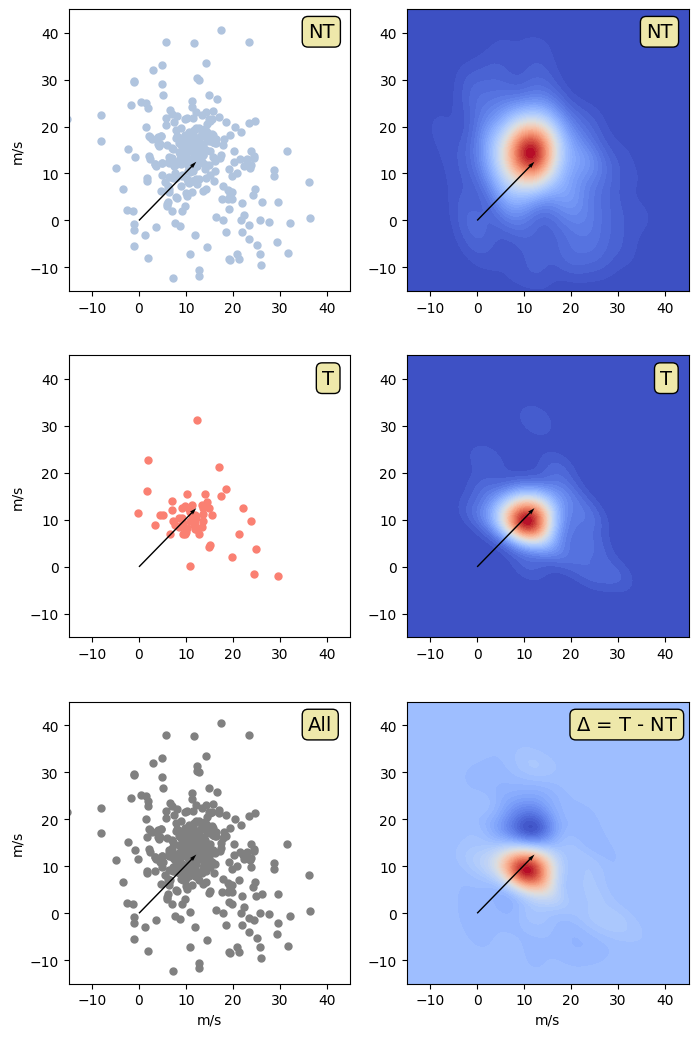

In [20]:
# Look into kernel density estimation

# Break into 3 Plots: Non-Tornadic, Tornadic, and All Together

# Create Storage Arrays For Each Plot
NT_u = []
NT_v = []
T_u = []
T_v = []
All_u = []
All_v = []

# Loop over each simulation's values, using the saved color as the discriminator
for sim in range(len(run_names)):
    for x in range(len(loaded_data[run_names[sim]][0])):
        # Read in Velocity/Color For Each Time per sim 
        u, v = loaded_data[run_names[sim]][0][x]
        color = loaded_data[run_names[sim]][1][x]
        
        # Save all velocities 
        All_u.append(u)
        All_v.append(v)
        
        # Parse into Tornadic vs. Non-Tornadic
        # Tornadic
        if color == 'red':
            T_u.append(u)
            T_v.append(v)
        # Non-Tornadic
        if color == 'blue':
            NT_u.append(u)
            NT_v.append(v)

# Convert to Arrays
NT_u = np.asarray(NT_u)
NT_v = np.asarray(NT_v)
T_u = np.asarray(T_u)
T_v = np.asarray(T_v)
All_u = np.asarray(All_u)
All_v = np.asarray(All_v)

# ------------------------------------------------------------------------------------------------------------------


# Create the 3 Plots 
fig, axs = plt.subplots(ncols = 2, nrows =3, figsize = (8,13), dpi = 100)
plt.subplots_adjust(wspace = 0.2)
# LEFT COLUMN: Raw Scatters Based on Tornadic/Non-Tornadic

# Top Plot: Non-Tornadic 
axs[0, 0].scatter(NT_u, NT_v, color = 'lightsteelblue', marker='o', linestyle='None', s = 25)
axs[0, 0].set_aspect('equal')
axs[0, 0].set_ylabel('m/s')
axs[0, 0].set_xlim(-15, 45)
axs[0, 0].set_ylim(-15, 45)
axs[0, 0].text(36, 39, 'NT', fontsize = 14, bbox = dict(facecolor = 'palegoldenrod', boxstyle = 'round'))

# Middle Plot: Tornadic
axs[1, 0].scatter(T_u, T_v, color = 'salmon', marker='o', linestyle='None', s = 25)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_ylabel('m/s')
axs[1, 0].set_xlim(-15, 45)
axs[1, 0].set_ylim(-15, 45)
axs[1, 0].text(39, 39, 'T', fontsize = 14, bbox = dict(facecolor = 'palegoldenrod', boxstyle = 'round'))


# Bottom Plot: All Values
axs[2, 0].scatter(All_u, All_v, color = 'gray', marker = 'o', linestyle = 'None', s = 25)
axs[2, 0].set_aspect('equal')
axs[2, 0].set_xlabel('m/s')
axs[2, 0].set_ylabel('m/s')
axs[2, 0].set_xlim(-15, 45)
axs[2, 0].set_ylim(-15, 45)
axs[2, 0].text(36, 39, 'All', fontsize=14,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))


# ------------------------------------------------------------------------------------------------------------------
# RIGHT COLUMN
# Perform KDE on each subset of velocities and plot

# Create a MeshGrid Consistent Across Plots
xmin, xmax = -15, 45
ymin, ymax = -15, 45
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

# Top Plot: Non-Tornadic
NonTor = np.vstack([NT_u, NT_v])
NT_KDE = gaussian_kde(NonTor)
zz_NT = NT_KDE(np.stack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
axs[0,1].contourf(xx, yy, zz_NT, levels=50, cmap = 'coolwarm')
axs[0,1].set_xlim(-15, 45)
axs[0,1].set_ylim(-15, 45)
axs[0,1].text(36, 39, 'NT', fontsize=14,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))
#axs[0,1].set_ylabel('m/s')
axs[0,1].set_aspect('equal')

# Middle: Tornadic
Tor = np.vstack([T_u, T_v])
T_KDE = gaussian_kde(Tor)
zz_T = T_KDE(np.stack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
axs[1, 1].contourf(xx, yy, zz_T, levels=50, cmap = 'coolwarm')
axs[1, 1].set_xlim(-15, 45)
axs[1, 1].set_ylim(-15, 45)
axs[1, 1].text(39, 39, 'T', fontsize=14,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))
#axs[1, 1].set_ylabel('m/s')
axs[1, 1].set_aspect('equal')

# Bottom: Difference Between Tornadic and NonTornadic
#All = np.vstack([All_u, All_v])
#All_KDE = gaussian_kde(All)
#zz_All = All_KDE(np.stack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
axs[2, 1].contourf(xx, yy, zz_T-zz_NT, levels=50, cmap = 'coolwarm')
axs[2, 1].set_xlim(-15, 45)
axs[2, 1].set_ylim(-15, 45)
axs[2, 1].set_xlabel('m/s')
axs[2, 1].text(21, 39, '${\Delta}$ = T - NT', fontsize=14,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))
axs[2, 1].set_aspect('equal')


# Plot the Mean Storm Motion Vector on Each Plot
start = np.array([0, 0])
end = np.array([12.2, 12.5])
dx, dy = end - start 

for y in range(2):
    for x in range(3):
        axs[x, y].quiver(start[0], start[1], dx, dy, angles='xy', scale_units='xy', scale=1,width = 0.005, color='k' )

# Title and layout 
#plt.suptitle('Kernel Density Estimation of Observed Storm Motions\n (All Ensemble Members: ${\Delta}$t = 5 min)', fontsize = 16, 
             #y = .93)



Text(0.5, 0.93, 'Kernel Density Estimation of Observed Storm Motions\n (All Ensemble Members: ${\\Delta}$t = 5 min)')

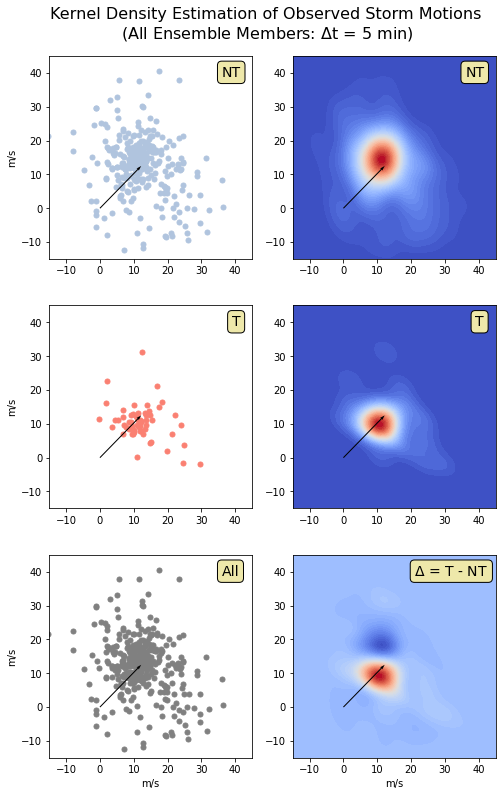

In [86]:
# Look into kernel density estimation

# Break into 3 Plots: Non-Tornadic, Tornadic, and All Together

# Create Storage Arrays For Each Plot
NT_u = []
NT_v = []
T_u = []
T_v = []
All_u = []
All_v = []

# Loop over each simulation's values, using the saved color as the discriminator
for sim in range(len(run_names)):
    for x in range(len(loaded_data[run_names[sim]][0])):
        # Read in Velocity/Color For Each Time per sim 
        u, v = loaded_data[run_names[sim]][0][x]
        color = loaded_data[run_names[sim]][1][x]
        
        # Save all velocities 
        All_u.append(u)
        All_v.append(v)
        
        # Parse into Tornadic vs. Non-Tornadic
        # Tornadic
        if color == 'red':
            T_u.append(u)
            T_v.append(v)
        # Non-Tornadic
        if color == 'blue':
            NT_u.append(u)
            NT_v.append(v)

# Convert to Arrays
NT_u = np.asarray(NT_u)
NT_v = np.asarray(NT_v)
T_u = np.asarray(T_u)
T_v = np.asarray(T_v)
All_u = np.asarray(All_u)
All_v = np.asarray(All_v)

# ------------------------------------------------------------------------------------------------------------------


# Create the 3 Plots 
fig, axs = plt.subplots(ncols = 2, nrows =3, figsize = (8,13))
plt.subplots_adjust(wspace = 0.2)
# LEFT COLUMN: Raw Scatters Based on Tornadic/Non-Tornadic

# Top Plot: Non-Tornadic 
axs[0, 0].scatter(NT_u, NT_v, color = 'lightsteelblue', marker='o', linestyle='None', s = 25)
axs[0, 0].set_aspect('equal')
axs[0, 0].set_ylabel('m/s')
axs[0, 0].set_xlim(-15, 45)
axs[0, 0].set_ylim(-15, 45)
axs[0, 0].text(36, 39, 'NT', fontsize = 14, bbox = dict(facecolor = 'palegoldenrod', boxstyle = 'round'))

# Middle Plot: Tornadic
axs[1, 0].scatter(T_u, T_v, color = 'salmon', marker='o', linestyle='None', s = 25)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_ylabel('m/s')
axs[1, 0].set_xlim(-15, 45)
axs[1, 0].set_ylim(-15, 45)
axs[1, 0].text(39, 39, 'T', fontsize = 14, bbox = dict(facecolor = 'palegoldenrod', boxstyle = 'round'))


# Bottom Plot: All Values
axs[2, 0].scatter(All_u, All_v, color = 'gray', marker = 'o', linestyle = 'None', s = 25)
axs[2, 0].set_aspect('equal')
axs[2, 0].set_xlabel('m/s')
axs[2, 0].set_ylabel('m/s')
axs[2, 0].set_xlim(-15, 45)
axs[2, 0].set_ylim(-15, 45)
axs[2, 0].text(36, 39, 'All', fontsize=14,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))


# ------------------------------------------------------------------------------------------------------------------
# RIGHT COLUMN
# Perform KDE on each subset of velocities and plot

# Create a MeshGrid Consistent Across Plots
xmin, xmax = -15, 45
ymin, ymax = -15, 45
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

# Top Plot: Non-Tornadic
NonTor = np.vstack([NT_u, NT_v])
NT_KDE = gaussian_kde(NonTor)
zz_NT = NT_KDE(np.stack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
axs[0,1].contourf(xx, yy, zz_NT, levels=50, cmap = 'coolwarm')
axs[0,1].set_xlim(-15, 45)
axs[0,1].set_ylim(-15, 45)
axs[0,1].text(36, 39, 'NT', fontsize=14,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))
#axs[0,1].set_ylabel('m/s')
axs[0,1].set_aspect('equal')

# Middle: Tornadic
Tor = np.vstack([T_u, T_v])
T_KDE = gaussian_kde(Tor)
zz_T = T_KDE(np.stack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
axs[1, 1].contourf(xx, yy, zz_T, levels=50, cmap = 'coolwarm')
axs[1, 1].set_xlim(-15, 45)
axs[1, 1].set_ylim(-15, 45)
axs[1, 1].text(39, 39, 'T', fontsize=14,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))
#axs[1, 1].set_ylabel('m/s')
axs[1, 1].set_aspect('equal')

# Bottom: Difference Between Tornadic and NonTornadic
#All = np.vstack([All_u, All_v])
#All_KDE = gaussian_kde(All)
#zz_All = All_KDE(np.stack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
axs[2, 1].contourf(xx, yy, zz_T-zz_NT, levels=50, cmap = 'coolwarm')
axs[2, 1].set_xlim(-15, 45)
axs[2, 1].set_ylim(-15, 45)
axs[2, 1].set_xlabel('m/s')
axs[2, 1].text(21, 39, '${\Delta}$ = T - NT', fontsize=14,  bbox = dict(facecolor = 'palegoldenrod', boxstyle='round' ))
axs[2, 1].set_aspect('equal')


# Plot the Mean Storm Motion Vector on Each Plot
start = np.array([0, 0])
end = np.array([12.2, 12.5])
dx, dy = end - start 

for y in range(2):
    for x in range(3):
        axs[x, y].quiver(start[0], start[1], dx, dy, angles='xy', scale_units='xy', scale=1,width = 0.005, color='k' )

# Title and layout 
plt.suptitle('Kernel Density Estimation of Observed Storm Motions\n (All Ensemble Members: ${\Delta}$t = 5 min)', fontsize = 16, 
             y = .93)



  0%|          | 0/30 [00:47<?, ?it/s]


KeyboardInterrupt: 

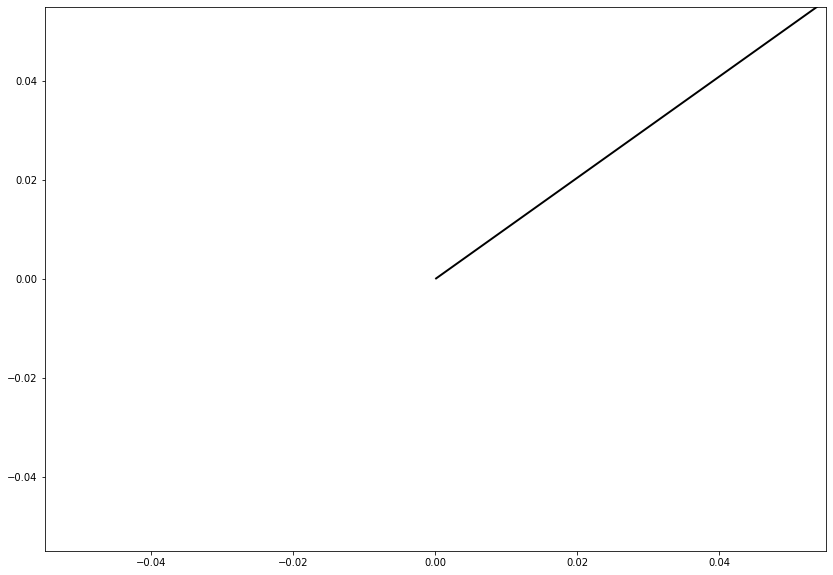

In [28]:
# Initialize Figure 
fig = plt.figure(figsize=(14,10))

# Plot Average Storm Motion as a Black Line
start = np.array([0, 0])
end = np.array([12.2, 12.5])
dx, dy = end - start
plt.quiver(start[0], start[1], dx, dy, angles='xy', scale_units='xy', scale=1,width = 0.0025, color='k')

# Calculate Adjusted Storm Motions At Each Timestep Starting at 1-hour
# Also find out if simulations are tornadic at any point within the upcoming 5 minutes
storm_motions = {}
for y in tqdm(np.arange(0, len(sim_paths),1)):
    velocities = []
    colors = []
    for x in np.arange(13, len(sim_names), 1):
        vel_u, vel_v = sm_adjusted(sim_paths[y], x, x+1)[0]
        color = TLV_check(run_names[y], x)
        velocities.append([vel_u ,vel_v])
        colors.append(color)
    storm_motions[run_names[y]] = [velocities, colors]
    
# Make A Scatter Plot of this data 
for x in tqdm(range(len(run_names))):
    for y in np.arange(0, 12, 1):
        plt.scatter(storm_motions[run_names[x]][0][y][0], storm_motions[run_names[x]][0][y][1], 
                    color = storm_motions[run_names[x]][1][y])
    
plt.xlim(0,30)    
plt.ylim(0,30)

# Create a scatter plot of where the soundings are obtained for each simulation and overlay the resulting maximum intensity of the storms 

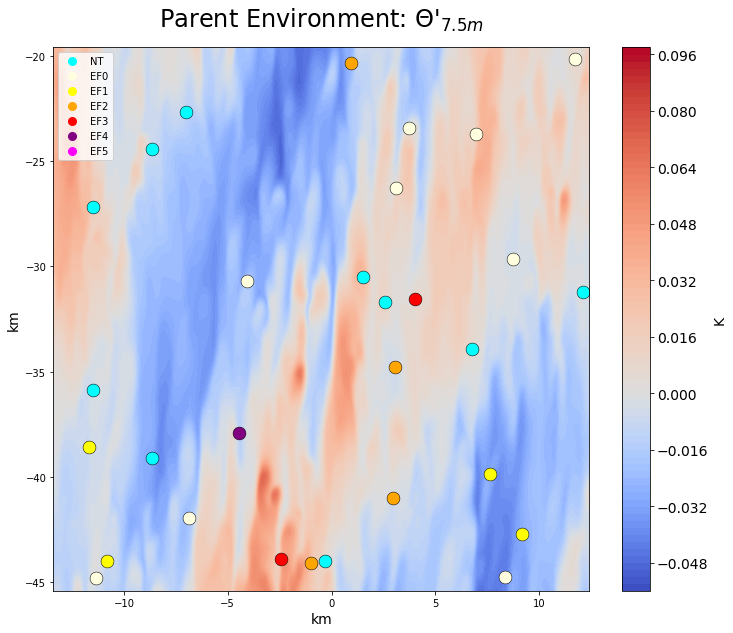

In [11]:
# Read in Storm 16 (t=0) Environment
storm16_data_path = '/storage/work/bsh5393/storm16/'
storm16_files = os.listdir(storm16_data_path)
#Remove Unneccessary Files From Storm 16 File List
storm16_files.remove('README-TIMELEVELS')
storm16_files.remove('namelist.input')
storm16_files.remove('runstorm16.pbs.o44255112')
storm16_files.remove('cm1out_stats.nc')
#Dataset at t = 0
storm_data = xr.open_dataset(storm16_data_path + storm16_files[0]).isel(time=0)


#Points From Trajectories (CASE 1: Southern Box)
path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE1-Southern Box/Data/'
traj_points = np.load(path+'interpolation_2_rawtrajectories.npz')['interp_points'][0] # only read in the first level of points
# Save IDs for each simulation to select correct points as an array
sounding_IDs = np.asarray([name.split('_')[1] for name in run_names], dtype = int)
# Use Sounding IDs to save sounding points
sounding_points = traj_points[sounding_IDs]

# Add a black outline to all the dots
# blue for NT, yellows to reds for T

# Create Color Scale For Dots and labels for legend
rating_to_color = {
    0:'cyan',
    1:'lightyellow',
    2:'yellow',
    3:'orange',
    4:'red',
    5:'purple',
    6:'magenta'
    
}
labels = ['NT', 'EF0', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5']

# Bounds for plotting 
y_min, y_max = round(traj_points[:,1].min())-.4, round(traj_points[:,1].max())+.4
x_min, x_max = round(traj_points[:,2].min())-.4, round(traj_points[:,2].max())+.4

# Initialize Plots and Set Bounds
fig = plt.figure(figsize=(12,10))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Define a diverging colormap
data = storm_data['th'].isel(nk=0) - storm_data['th'].isel(nk=0).mean()
cmap = plt.cm.coolwarm  # Red-Blue colormap
norm = mcolors.TwoSlopeNorm(vmin=data.min(), vcenter=0, vmax=data.max())

#Plot the Potential Temperature Field at t = 0
th = plt.contourf(x_data, y_data, data, levels =100, cmap='coolwarm', norm=norm)

# Plot the Individual Sounding Locations with their associated maximum tornado intensity
for x in range(len(sounding_points)):
    plt.scatter(sounding_points[x][2], sounding_points[x][1], color=rating_to_color[hist_rating[x]], s=165, edgecolor='k', linewidth=0.5)
    
# Create legend handles
legend_handles = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=f'{labels[rating]}')
    for rating, color in rating_to_color.items()
]
plt.legend(handles=legend_handles, loc= 'upper left')
plt.title('Parent Environment: $\Theta$\'$_{7.5 m}$', fontsize=24, pad = 20)
'Storm 16 Potential Temperature Perturbation Field (t = 0 min.)'
plt.xlabel('km', fontsize = 14)
plt.ylabel('km', fontsize = 14)
cbar = plt.colorbar(th)
cbar.set_label("K", fontsize=14)
cbar.ax.tick_params(labelsize=14) 

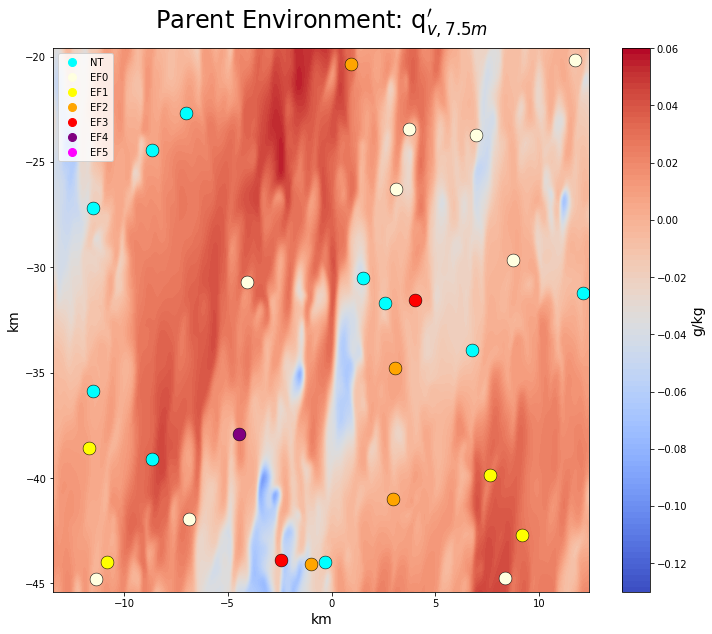

In [19]:
# Initialize Plots and Set Bounds
fig = plt.figure(figsize=(12,10))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)


# Define a diverging colormap
data = storm_data['qv'].isel(nk=0) - storm_data['qv'].isel(nk=0).mean()
cmap = plt.cm.coolwarm  # Red-Blue colormap
norm = mcolors.TwoSlopeNorm(vmin=data.min(), vcenter=0, vmax=data.max())

#Plot the Potential Temperature Perturbation Field at t = 0
qv = plt.contourf(x_data, y_data, data*1000, levels =100, cmap='coolwarm')

# Plot the Individual Sounding Locations with their associated maximum tornado intensity
for x in range(len(sounding_points)):
    plt.scatter(sounding_points[x][2], sounding_points[x][1], color=rating_to_color[hist_rating[x]], s=165, edgecolor='k', linewidth=0.5)
    
# Create legend handles
legend_handles = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=f'{labels[rating]}')
    for rating, color in rating_to_color.items()
]
plt.legend(handles=legend_handles, loc= 'upper left')
plt.title("Parent Environment: q$'_{v, 7.5 m}$", fontsize=24, pad = 20)
plt.xlabel('km', fontsize = 14)
plt.ylabel('km', fontsize = 14)
cbar = plt.colorbar(qv)
cbar.set_label("g/kg", fontsize=14)

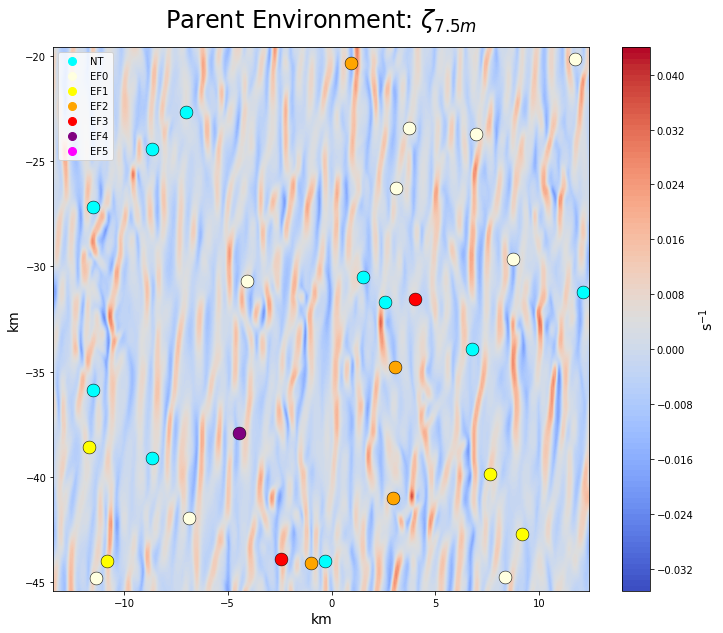

In [13]:
# Initialize Plots and Set Bounds
fig = plt.figure(figsize=(12,10))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

#Plot the Potential Temperature Perturbation Field at t = 0
zvort = plt.contourf(x_data, y_data, storm_data['zvort'].isel(nk=0), levels =100, cmap='coolwarm')

# Plot the Individual Sounding Locations with their associated maximum tornado intensity
for x in range(len(sounding_points)):
    plt.scatter(sounding_points[x][2], sounding_points[x][1], color=rating_to_color[hist_rating[x]], s=165, edgecolor='k', linewidth=0.5)
    
# Create legend handles
legend_handles = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=f'{labels[rating]}')
    for rating, color in rating_to_color.items()
]
plt.legend(handles=legend_handles, loc= 'upper left')
plt.title('Parent Environment: $\zeta_{7.5 m}$', fontsize=24, pad = 20)
plt.xlabel('km', fontsize = 14)
plt.ylabel('km', fontsize = 14)
cbar = plt.colorbar(zvort)
cbar.set_label('s$^{-1}$', fontsize=14)

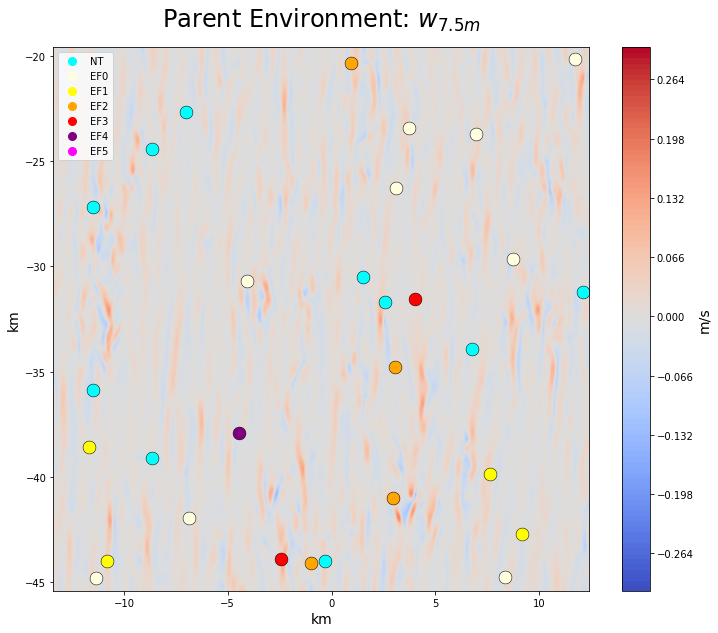

In [14]:
#surface wind speed and/or surface vertical velocity as well 
# Initialize Plots and Set Bounds
fig = plt.figure(figsize=(12,10))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

#Plot the Potential Temperature Perturbation Field at t = 0
w = plt.contourf(x_data, y_data, storm_data['winterp'].isel(nk=0), levels =100, cmap='coolwarm')

# Plot the Individual Sounding Locations with their associated maximum tornado intensity
for x in range(len(sounding_points)):
    plt.scatter(sounding_points[x][2], sounding_points[x][1], color=rating_to_color[hist_rating[x]], s=165, edgecolor='k', linewidth=0.5)
    
# Create legend handles
legend_handles = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=f'{labels[rating]}')
    for rating, color in rating_to_color.items()
]
plt.legend(handles=legend_handles, loc= 'upper left')
plt.title('Parent Environment: $w_{7.5 m}$', fontsize=24, pad = 20)
plt.xlabel('km', fontsize = 14)
plt.ylabel('km', fontsize = 14)
cbar = plt.colorbar(w)
cbar.set_label('m/s', fontsize=14)

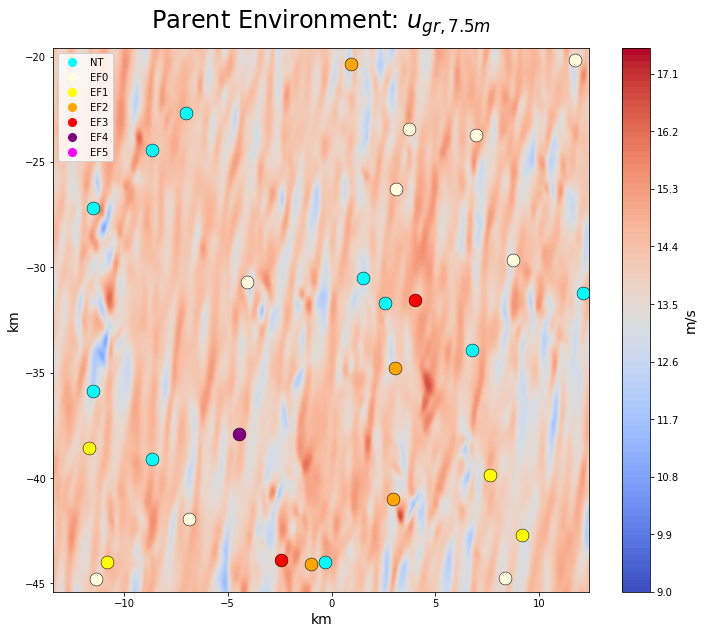

In [15]:
#surface wind speed and/or surface vertical velocity as well 
# Initialize Plots and Set Bounds
fig = plt.figure(figsize=(12,10))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

#Plot the Potential Temperature Perturbation Field at t = 0
gr_wind = plt.contourf(x_data, y_data, (storm_data['uinterp'].isel(nk=0)**2 + storm_data['vinterp'].isel(nk=0)**2)**(0.5) , levels =100, cmap='coolwarm')

# Plot the Individual Sounding Locations with their associated maximum tornado intensity
for x in range(len(sounding_points)):
    plt.scatter(sounding_points[x][2], sounding_points[x][1], color=rating_to_color[hist_rating[x]], s=165, edgecolor='k', linewidth=0.5)
    
# Create legend handles
legend_handles = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=f'{labels[rating]}')
    for rating, color in rating_to_color.items()
]
plt.legend(handles=legend_handles, loc= 'upper left')
plt.title("Parent Environment: $u_{gr, 7.5 m}$", fontsize=24, pad = 20)
plt.xlabel('km', fontsize = 14)
plt.ylabel('km', fontsize = 14)
cbar = plt.colorbar(gr_wind)
cbar.set_label('m/s', fontsize=14)

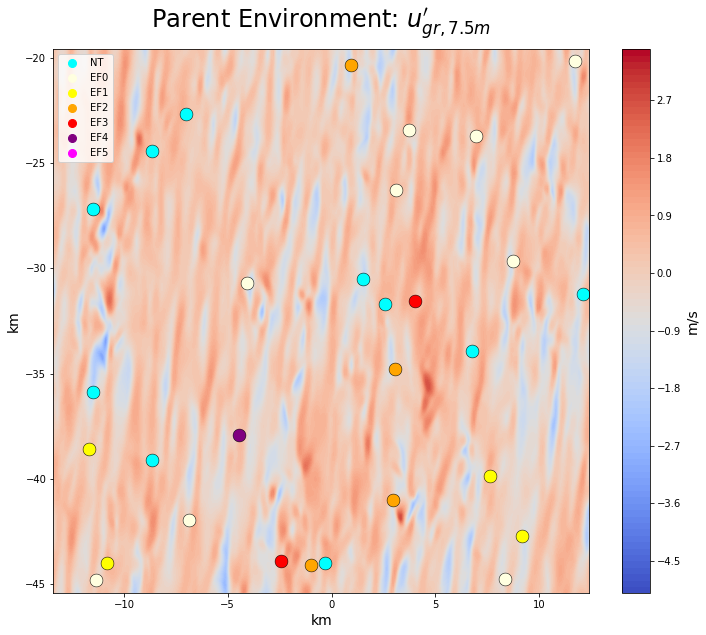

In [16]:
#surface wind speed and/or surface vertical velocity as well 
# Initialize Plots and Set Bounds
fig = plt.figure(figsize=(12,10))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)


# Define a diverging colormap
data = (storm_data['uinterp'].isel(nk=0)**2 + 
        storm_data['vinterp'].isel(nk=0)**2)**(0.5) - ((storm_data['uinterp'].isel(nk=0)**2 
                                                        + storm_data['vinterp'].isel(nk=0)**2)**(0.5)).mean()
cmap = plt.cm.coolwarm  # Red-Blue colormap
norm = mcolors.TwoSlopeNorm(vmin=data.min(), vcenter=0, vmax=data.max())

#Plot the Potential Temperature Perturbation Field at t = 0
gr_wind_dev = plt.contourf(x_data, y_data, data, levels =100, cmap='coolwarm')

# Plot the Individual Sounding Locations with their associated maximum tornado intensity
for x in range(len(sounding_points)):
    plt.scatter(sounding_points[x][2], sounding_points[x][1], color=rating_to_color[hist_rating[x]], s=165, edgecolor='k', linewidth=0.5)
    
# Create legend handles
legend_handles = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=f'{labels[rating]}')
    for rating, color in rating_to_color.items()
]
plt.legend(handles=legend_handles, loc= 'upper left')
plt.title("Parent Environment: $u_{gr, 7.5 m}'$", fontsize=24, pad = 20)
plt.xlabel('km', fontsize = 14)
plt.ylabel('km', fontsize = 14)
cbar = plt.colorbar(gr_wind_dev)
cbar.set_label('m/s', fontsize=14)

In [17]:
# Calculate Significant Tornado Parameter For Storm16 Environment
# Need: SBCAPE, SBCIN, SBLCL, SRH1km, 6km BWD

# Step 1: Figure out the bounds of computations based on the random sounding locations to cut down compuational time
x_inds = (np.argmin(np.abs(x_data.values-x_min))-3, np.argmin(np.abs(x_data.values-x_max))+3)
y_inds = (np.argmin(np.abs(y_data.values-y_min))-3, np.argmin(np.abs(y_data.values-y_max))+3)

# Step 2: CAPE and CIN (implementing wrf: edited by me via GitHub to tweak incorrect SRH calculations)

# Import Necessary Variables 
qv = storm_data['qv'].isel(nj = slice(y_inds[0], y_inds[1]), ni = slice(x_inds[0], x_inds[1])) # Specific Humidity 
P = storm_data['prs'].isel(nj = slice(y_inds[0], y_inds[1]), ni = slice(x_inds[0], x_inds[1]))/100 # Pressure 
Th = storm_data['th'].isel(nj = slice(y_inds[0], y_inds[1]), ni = slice(x_inds[0], x_inds[1])) # Potential Temperature
# Calculate Remaining Variables 
T = mpcalc.temperature_from_potential_temperature(P*units.hPa, Th*units.kelvin) # Temperature
z = np.asarray(z_data*1000).reshape(121,1,1) #"Geopotential Height"
Height = np.tile(z, (1, np.diff(y_inds)[0], np.diff(x_inds)[0])) #"Geopotential Height"
Terrain = np.full((np.diff(y_inds)[0], np.diff(x_inds)[0]),0) #Terrain (Assuming Flat Surface)
P_sfc = P[0].values # Surface Pressure
# WRF CAPE Computation
results = wrf.cape_3d(P, T, qv, Height, Terrain, P_sfc, ter_follow = True, meta = True)
CAPE = results[0][0]
CIN = results[1][0]

# Step 3: Storm Relative Helicity
u = storm_data['uinterp'].isel(nj = slice(y_inds[0], y_inds[1]), ni = slice(x_inds[0], x_inds[1])) # m/s
v = storm_data['vinterp'].isel(nj = slice(y_inds[0], y_inds[1]), ni = slice(x_inds[0], x_inds[1])) # m/s
SRH1km = wrf.srhel(u,v,Height, Terrain, top = 1000)

# Step 4: Bulk Wind Difference (0-6 km)

#Height Indexes of Interest
z_6km = (np.abs(z_data.values - 6)).argmin()
z_0km = 0 # Right now this is z = 7.5 m

# Grab Velocities 
u_6km = storm_data['uinterp'].isel(nk = z_6km, nj = slice(y_inds[0], y_inds[1]), ni = slice(x_inds[0], x_inds[1])) # m/s
v_6km = storm_data['vinterp'].isel(nk = z_6km, nj = slice(y_inds[0], y_inds[1]), ni = slice(x_inds[0], x_inds[1])) # m/s
u_0km = storm_data['uinterp'].isel(nk = z_0km, nj = slice(y_inds[0], y_inds[1]), ni = slice(x_inds[0], x_inds[1])) # m/s
v_0km = storm_data['vinterp'].isel(nk = z_0km, nj = slice(y_inds[0], y_inds[1]), ni = slice(x_inds[0], x_inds[1])) # m/s

# Bulk Wind Difference 
BWD_u = u_6km - u_0km
BWD_v = v_6km - v_0km
BWD = (BWD_u**2 + BWD_v**2)**(1/2)

# Step 5: Find The LCL 
# Approximation for LCL: Difference between the surface tempearture 
# and dewpoint temperature in degrees Celsius divided by 8 gives a rough estimate of LCL in km
# UPDATE: This is not rigorous enough, find dewpoint of 10 profiles in the domain, find the LCL 
# in those 10 spots, and take the average and call the LCL accross the domain that
# Find Dewpoint: Randomly Select 10 Points in Domain to Calculate LCL at
Td = wrf.td(P, qv) + 273.15
# Storage
LCLs = np.zeros(10)

for x in range(10):
    # Select Random Location
    i = random.randint(0, P.shape[1]) # random east-west index
    j = random.randint(0, P.shape[1]) # random north-south index
    
    # Calculate LCL using metpy
    LCL_press = mpcalc.lcl(P.isel(nk=0, nj=j, ni=i)*units('hPa'), T.isel(nk=0,nj=j, ni=i), Td.isel(nk=0, nj=j, ni=i)*units('degK'))[0]
    
    #Convert LCL pressure to height
    LCL_m = mpcalc.pressure_to_height_std(LCL_press)
    # Append LCL
    LCLs[x] = LCL_m.magnitude
    
# Take Average and Call that the LCL across domain
SB_LCL = LCLs.mean()*1000

# Final Step: Calculate STP
STP = (CAPE.values/1500)*((2000-SB_LCL)/1000)*(SRH1km.values/150)*((200+CIN.values)/150)*(BWD/20)

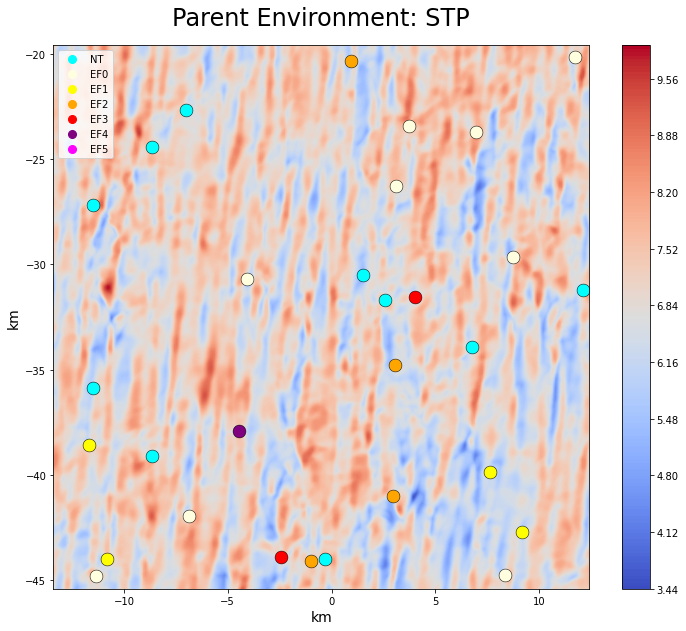

In [18]:
# Plot STP
# Initialize Plots and Set Bounds
fig = plt.figure(figsize=(12,10))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

#Plot the Potential Temperature Perturbation Field at t = 0
STP_plot = plt.contourf(x_data[x_inds[0]:x_inds[1]], y_data[y_inds[0]:y_inds[1]], STP, levels =200, cmap='coolwarm')

# Plot the Individual Sounding Locations with their associated maximum tornado intensity
for x in range(len(sounding_points)):
    plt.scatter(sounding_points[x][2], sounding_points[x][1], color=rating_to_color[hist_rating[x]], s=165, edgecolor='k', linewidth=0.5)
    
# Create legend handles
legend_handles = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=f'{labels[rating]}')
    for rating, color in rating_to_color.items()
]
plt.legend(handles=legend_handles, loc= 'upper left')
plt.title("Parent Environment: STP", fontsize=24, pad = 20)
plt.xlabel('km', fontsize = 14)
plt.ylabel('km', fontsize = 14)
cbar = plt.colorbar(STP_plot)

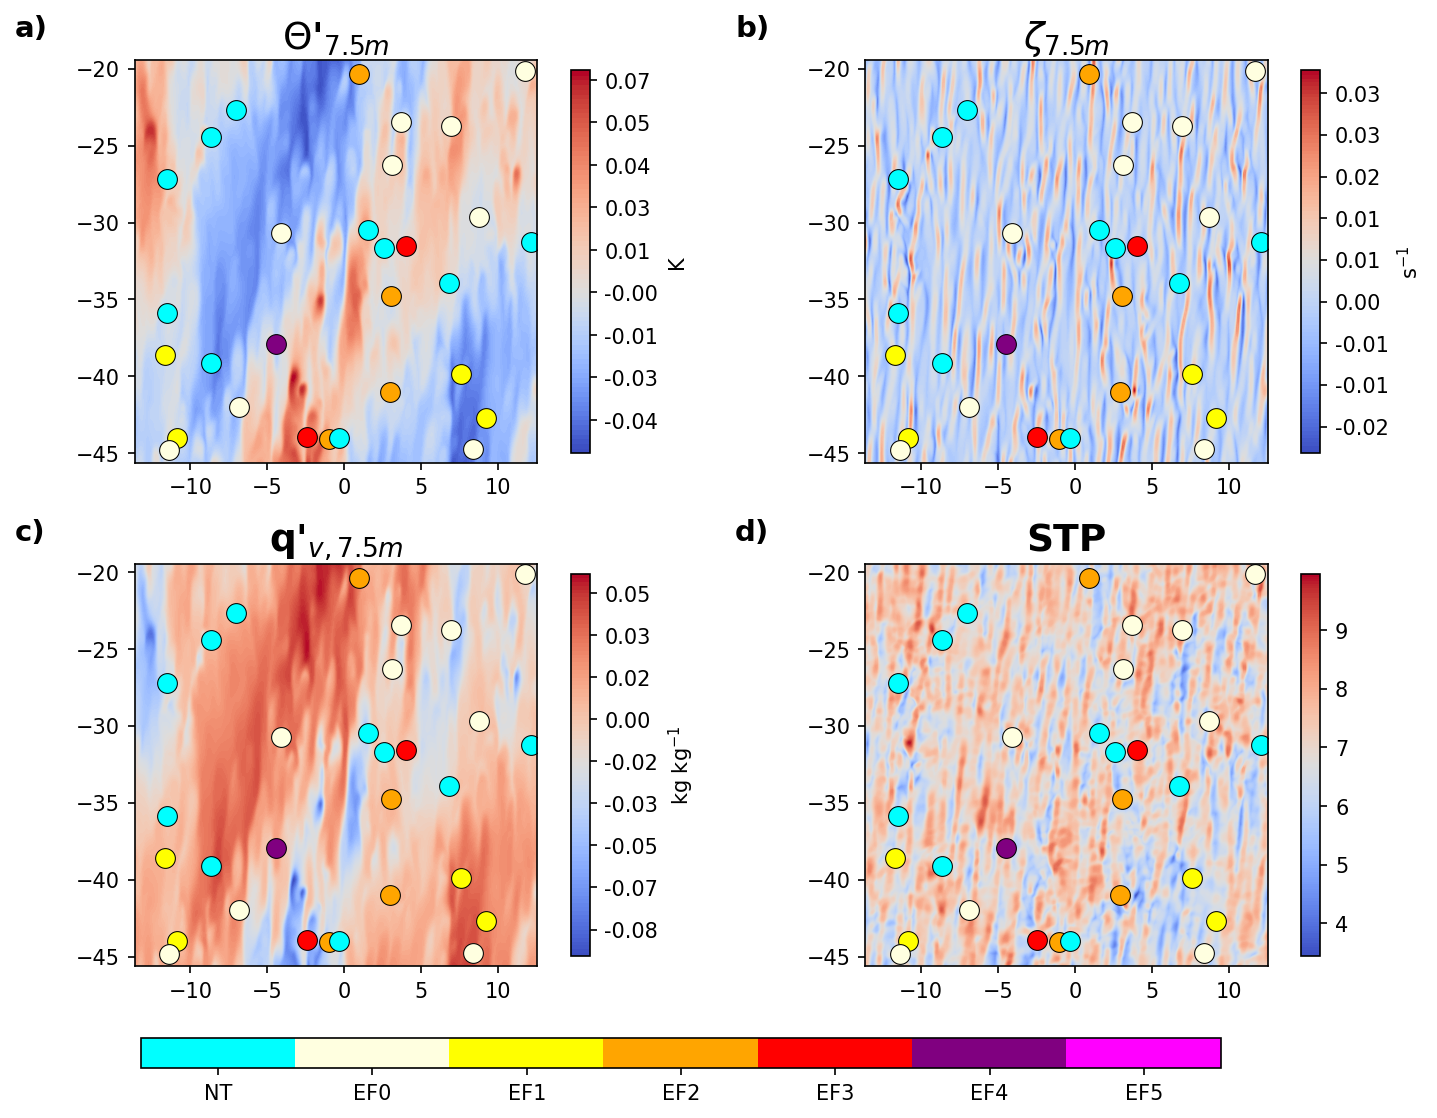

In [25]:
from matplotlib.ticker import FormatStrFormatter

# Combine all above plots
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (12,8), dpi = 150)
plt.subplots_adjust(wspace=0.1, hspace=0.25)

# Bounds for plots
x_inds = (np.argmin(np.abs(x_data.values-x_min))-3, np.argmin(np.abs(x_data.values-x_max))+3)
y_inds = (np.argmin(np.abs(y_data.values-y_min))-3, np.argmin(np.abs(y_data.values-y_max))+3)

# Axis 1: Theta Pert 
th_data = storm_data['th'].isel(nk=0, nj=slice(y_inds[0], y_inds[1]), ni = slice(x_inds[0], x_inds[1])) - storm_data['th'].isel(nk=0).mean()
cmap = plt.cm.coolwarm  # Red-Blue colormap
norm = mcolors.TwoSlopeNorm(vmin=th_data.min(), vcenter=0, vmax=th_data.max())
ax1 = axs[0,0].contourf(x_data[x_inds[0]:x_inds[1]], y_data[y_inds[0]:y_inds[1]], th_data, levels =100, cmap='coolwarm', norm=norm)
cbar1 = fig.colorbar(ax1, ax=axs[0, 0], orientation='vertical', shrink = 0.95, label= 'K')
axs[0,0].set_aspect('equal')
axs[0,0].set_title('$\Theta$\'$_{7.5 m}$', fontsize=18, weight='bold')
cbar1.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Axis 2: qv pert
qv_data = storm_data['qv'].isel(nk=0, nj=slice(y_inds[0], y_inds[1]), ni = slice(x_inds[0], x_inds[1])) - storm_data['qv'].isel(nk=0).mean()
cmap = plt.cm.coolwarm  # Red-Blue colormap
norm = mcolors.TwoSlopeNorm(vmin=qv_data.min(), vcenter=0, vmax=qv_data.max())
ax2 = axs[1, 0].contourf(x_data[x_inds[0]:x_inds[1]], y_data[y_inds[0]:y_inds[1]], qv_data*1000, levels =100, cmap='coolwarm')
cbar2 = fig.colorbar(ax2, ax=axs[1, 0], orientation='vertical', shrink = 0.95, label = 'kg kg$^{-1}$')
axs[1, 0].set_aspect('equal')
axs[1,0].set_title("q'$_{v, 7.5 m}$", fontsize=18, weight='bold')
cbar2.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# # Axis 3: zvort
ax3 = axs[0, 1].contourf(x_data[x_inds[0]:x_inds[1]], y_data[y_inds[0]:y_inds[1]], storm_data['zvort'].isel(nk=0, nj=slice(y_inds[0], y_inds[1]), ni=slice(x_inds[0], x_inds[1])), levels =100, cmap='coolwarm')
cbar3 = fig.colorbar(ax3, ax=axs[0, 1], orientation='vertical', shrink = 0.95, label = 's$^{-1}$')
axs[0, 1].set_aspect('equal')
axs[0,1].set_title('$\zeta_{7.5 m}$', fontsize=18, weight='bold')
cbar3.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


# Axis 6: STP
ax6 = axs[1, 1].contourf(x_data[x_inds[0]:x_inds[1]], y_data[y_inds[0]:y_inds[1]], STP, levels =200, cmap='coolwarm')
cbar4 = fig.colorbar(ax6, ax=axs[1, 1], orientation='vertical', shrink = 0.95, ticks =np.arange(3,10, 1))
axs[1,1].set_aspect('equal')
axs[1,1].set_title('STP', fontsize=18, weight='bold')

# Create Color Scale For Dots and labels for legend
rating_to_color = {
    0:'cyan',
    1:'lightyellow',
    2:'yellow',
    3:'orange',
    4:'red',
    5:'purple',
    6:'magenta'
    
}
labels = ['NT', 'EF0', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5']

# Plot the Individual Sounding Locations with their associated maximum tornado intensity
for ax in axs.flat:
    for x in range(len(sounding_points)):
        ax.scatter(sounding_points[x][2], sounding_points[x][1], color=rating_to_color[hist_rating[x]], s=90, edgecolor='k', linewidth=0.5)
    
# Add text labels to each top right corner
fig.text(0.13, 0.9, 'a)', fontsize = 14, weight = 'demibold')
fig.text(0.53, 0.9, 'b)', fontsize = 14, weight = 'demibold')
# fig.text(0.66, 0.9, 'c)', fontsize = 14, weight = 'demibold')
fig.text(0.13, 0.48, 'c)', fontsize = 14, weight = 'demibold')
fig.text(0.53, 0.48, 'd)', fontsize = 14, weight = 'demibold')
# fig.text(0.66, 0.48, 'f)', fontsize = 14, weight = 'demibold')

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in range(7)])
norm = mcolors.BoundaryNorm(np.arange(8), cmap.N)  # 7 levels + 1 boundary
# Create a ScalarMappable for legend colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add a new axes *below* the subplots for the global colorbar
cbar_ax = fig.add_axes([0.2, 0.04, 0.6, 0.025])  # [left, bottom, width, height]
cbar = fig.colorbar(
    sm,
    cax=cbar_ax,
    orientation="horizontal",
    ticks=np.arange(7) + 0.5
)
cbar.ax.set_xticklabels(["NT", "EF0", "EF1", "EF2", "EF3", "EF4", "EF5"])
cbar.ax.tick_params(labelsize=10)

# The following cells below create Figures from Markowksi 2020 looking at ensemble characteristics/storms 

- Figure 11: Time Series Divided Up By SIGTOR/WEAKTOR/NONTOR or TOR/NONTOR of a) potential temperature perturbations, b) maximum vertical velocity at 1 km, c) maximum vertical vorticity at 7.5 m, d) something else (maybe VPPGA)
- Figure 12: Select Fields 5 min before the genesis of significant tornadoes in the SIGTOR sims
- Start with the above two and see where I end up

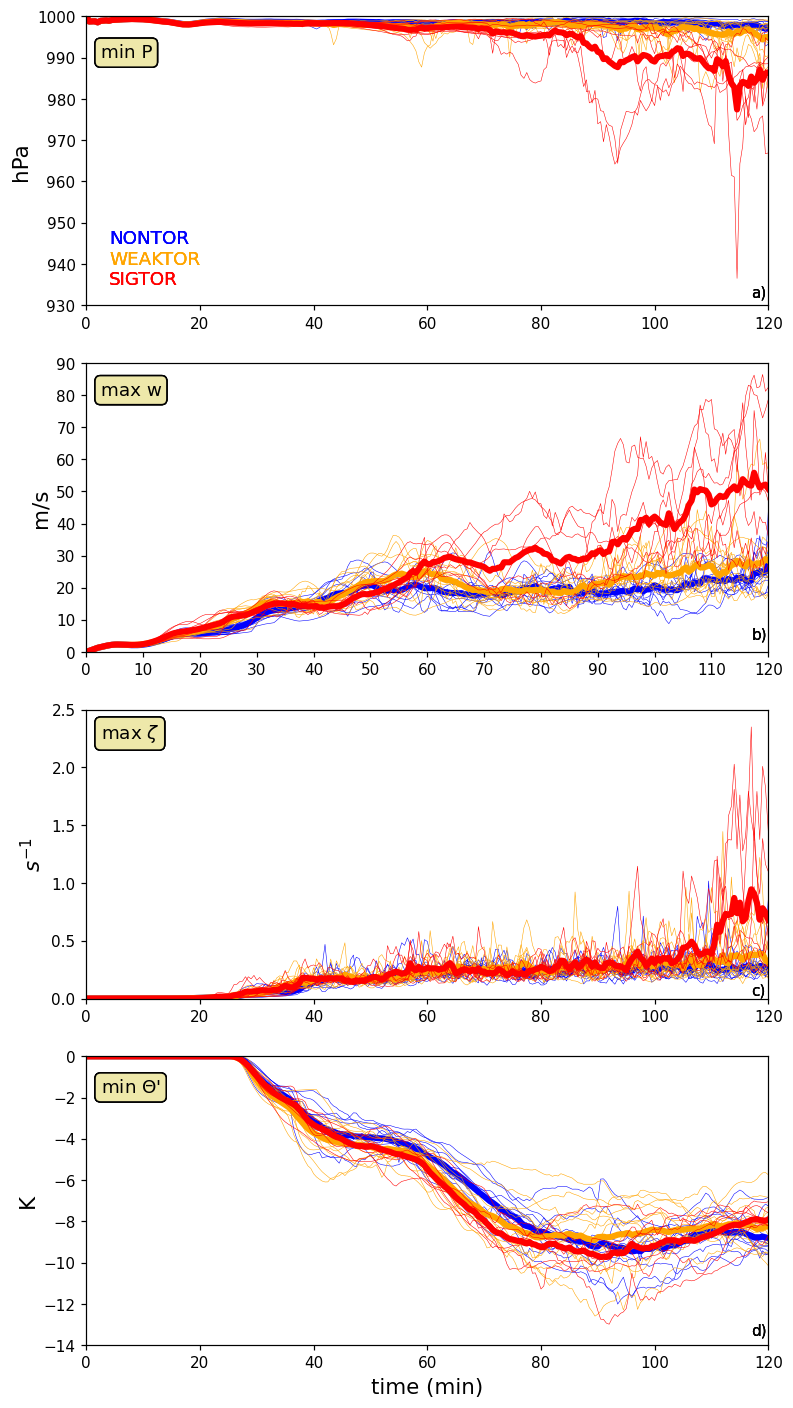

In [22]:
# Figure 11: Creating Timeseries of select variables (NT, WT, ST)

# Firstly, divide the storm characterization dictionary into individual keys (NT, WT, ST)
types = list(sim_type.keys())

# Initialize Figure: Let's try one variable first (maximum vertical velocity at 1km - can use the stats files for this: dt = 30 s)
fig, axs = plt.subplots(ncols = 1, nrows = 4, figsize=(8,16), dpi = 110)
time_ind = np.linspace(0,120, 241) # time index: in units of minutes 

# Colors for Type of Sim: b - NT, o - WT, r - ST
colors = ['blue', 'orange', 'red']

# Loop over each simulation type 
for category in range(len(sim_type)):
    # Empty List For Storage of Data From Each Ensemble Member
    mean_w = []
    mean_pmin = []
    mean_vort = []
    mean_thpert = []
    # Loop over each ensemble member per type and plot the timeseries
    for sim in sim_type[types[category]]:
        # Select Appropriate Color
        color = colors[category]
        
        # Read In Stats File for ensemble member
        stats = xr.open_dataset(sim_paths[sim] + '/' + 'cm1out_stats.nc')[['wmax1000', 'psfcmin','vortsfc', 'sthpmin']]
        
        # Plot Time Series for each variable
        
        # Pressure Minima: z = 7.5 m
        axs[0].plot(time_ind, stats['psfcmin']/100, color = color, linewidth = 0.35)
        
        # Vertical Velocity Maxima at z = 1 km
        axs[1].plot(time_ind, stats['wmax1000'], color = color, linewidth = 0.35)
        
        # Vorticity Minima: z = 7.5 m
        axs[2].plot(time_ind, stats['vortsfc'], color = color, linewidth = 0.35)
        
        # Potential Temperature Perturbation Minima: z = 7.5 m 
        axs[3].plot(time_ind, stats['sthpmin'], color = color, linewidth = 0.35)
        
        # Append Stats For Each Ensemble
        mean_w.append(stats['wmax1000'].values)
        mean_pmin.append(stats['psfcmin'].values/100)
        mean_vort.append(stats['vortsfc'].values)
        mean_thpert.append(stats['sthpmin'].values)
        
        # ----------------------------------------------------------------------------------------------------------------
    
    # Cosmetics
    
    # Plot 1: 
    axs[0].set_ylabel('hPa', fontsize=14)
    axs[0].set_xlim(0, 120)
    axs[0].set_ylim(930, 1000)
    axs[0].text(2.5, 990, 'min P', fontsize=12, bbox=dict(facecolor='palegoldenrod', boxstyle='round'))
    axs[0].text(117, 932, 'a)')
    # Add each line separately with different colors
    axs[0].text(4, 945, "NONTOR", color='blue', fontsize=12)
    axs[0].text(4, 940, "WEAKTOR", color='orange', fontsize=12)
    axs[0].text(4, 935, "SIGTOR", color='red', fontsize=12)

    # Plot 2:
    axs[1].set_ylabel('m/s', fontsize=14)
    axs[1].set_xticks(np.arange(0, 121, 10))
    axs[1].set_xlim(0, 120)
    axs[1].set_ylim(0, 90)
    axs[1].text(2.5, 80, 'max w', fontsize=12, bbox=dict(facecolor='palegoldenrod', boxstyle='round'))
    axs[1].text(117, 4, 'b)')
         
    # Plot 3: 
    axs[2].set_ylabel('$s^{-1}$', fontsize=14)
    axs[2].set_xlim(0, 120)
    axs[2].set_ylim(0, 2.5)
    axs[2].text(2.5, 2.25, 'max $\zeta$ ', fontsize=12, bbox=dict(facecolor='palegoldenrod', boxstyle='round'))
    axs[2].text(117, .035, 'c)')
    
    # Plot 4:
    axs[3].set_ylabel('K', fontsize=14)
    axs[3].set_xlabel('time (min)', fontsize=14)
    axs[3].set_xlim(0, 120)
    axs[3].set_ylim(-14,0)
    axs[3].text(2.5, -1.75, 'min $\Theta$\'', fontsize=12, bbox=dict(facecolor='palegoldenrod', boxstyle='round'))
    axs[3].text(117, -13.5, 'd)')
    
    # --------------------------------------------------------------------------------------------------------------------
    
    # Convert list to array and take the average of all members per category 
    mean_w = np.asarray(mean_w).mean(axis=0)
    mean_pmin = np.asarray(mean_pmin).mean(axis=0)
    mean_vort = np.asarray(mean_vort).mean(axis=0)
    mean_thpert = np.asarray(mean_thpert).mean(axis=0)
    
    # Plot Ensemble Mean per type
    axs[0].plot(time_ind, mean_pmin, color = color, linewidth = 4)
    axs[1].plot(time_ind, mean_w, color = color, linewidth = 4)
    axs[2].plot(time_ind, mean_vort, color = color, linewidth = 4)
    axs[3].plot(time_ind, mean_thpert, color = color, linewidth = 4)
    

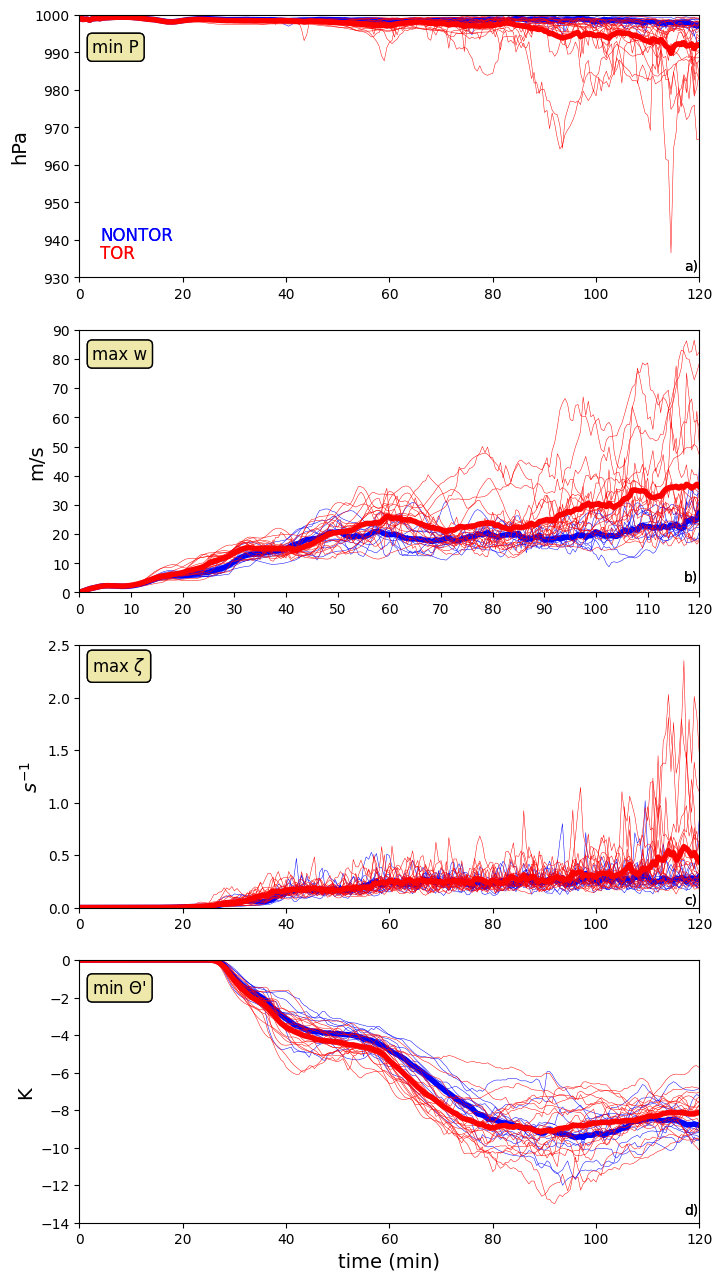

In [23]:
# Figure 11: Creating Timeseries of select variables (NT, T)

# Firstly, divide the storm characterization dictionary into individual keys (NT, WT, ST)
types = list(sim_type.keys())
# Now combine ST, WT
types = dict({types[0]: sim_type[types[0]],
     'Tornadic': np.concatenate((sim_type[types[1]], sim_type[types[2]]), axis=0)})
labels = list(types.keys())
# Initialize Figure: Let's try one variable first (maximum vertical velocity at 1km - can use the stats files for this: dt = 30 s)
fig, axs = plt.subplots(ncols = 1, nrows = 4, figsize=(8,16), dpi = 100)
time_ind = np.linspace(0,120, 241) # time index: in units of minutes 

# Colors for Type of Sim: b - NT, o - WT, r - ST
colors = ['blue', 'red']

# Loop over each simulation type 
for category in range(len(labels)):
    # Empty List For Storage of Data From Each Ensemble Member
    mean_w = []
    mean_pmin = []
    mean_vort = []
    mean_thpert = []
    # Loop over each ensemble member per type and plot the timeseries
    for sim in types[labels[category]]:
        # Select Appropriate Color
        color = colors[category]
        
        # Read In Stats File for ensemble member
        stats = xr.open_dataset(sim_paths[sim] + '/' + 'cm1out_stats.nc')[['wmax1000', 'psfcmin','vortsfc', 'sthpmin']]
        
        # Plot Time Series for each variable
        # Pressure Minima: z = 7.5 m
        axs[0].plot(time_ind, stats['psfcmin']/100, color = color, linewidth = 0.35)
        
        # Vertical Velocity Maxima at z = 2 km
        axs[1].plot(time_ind, stats['wmax1000'], color = color, linewidth = 0.35)
        
        # Vorticity Minima: z = 7.5 m
        axs[2].plot(time_ind, stats['vortsfc'], color = color, linewidth = 0.35)
        
        # Potential Temperature Perturbation Minima: z = 7.5 m 
        axs[3].plot(time_ind, stats['sthpmin'], color = color, linewidth = 0.35)
        
        # Append Stats For Each Ensemble
        mean_w.append(stats['wmax1000'].values)
        mean_pmin.append(stats['psfcmin'].values/100)
        mean_vort.append(stats['vortsfc'].values)
        mean_thpert.append(stats['sthpmin'].values)
        
        # ----------------------------------------------------------------------------------------------------------------
    
    # Cosmetics
    
    # Plot 1: 
    axs[0].set_ylabel('hPa', fontsize=14)
    axs[0].set_xlim(0, 120)
    axs[0].set_ylim(930, 1000)
    axs[0].text(2.5, 990, 'min P', fontsize=12, bbox=dict(facecolor='palegoldenrod', boxstyle='round'))
    axs[0].text(117, 932, 'a)')
    # Add each line separately with different colors
    axs[0].text(4, 940, "NONTOR", color='blue', fontsize=12)
    axs[0].text(4, 935, "TOR", color='red', fontsize=12)

       
    # Plot 2:
    axs[1].set_ylabel('m/s', fontsize=14)
    axs[1].set_xticks(np.arange(0, 121, 10))
    axs[1].set_xlim(0, 120)
    axs[1].set_ylim(0, 90)
    axs[1].text(2.5, 80, 'max w', fontsize=12, bbox=dict(facecolor='palegoldenrod', boxstyle='round'))
    axs[1].text(117, 4, 'b)')
         
    # Plot 3: 
    axs[2].set_ylabel('$s^{-1}$', fontsize=14)
    axs[2].set_xlim(0, 120)
    axs[2].set_ylim(0, 2.5)
    axs[2].text(2.5, 2.25, 'max $\zeta$ ', fontsize=12, bbox=dict(facecolor='palegoldenrod', boxstyle='round'))
    axs[2].text(117, .035, 'c)')
    
    # Plot 4:
    axs[3].set_ylabel('K', fontsize=14)
    axs[3].set_xlabel('time (min)', fontsize=14)
    axs[3].set_xlim(0, 120)
    axs[3].set_ylim(-14,0)
    axs[3].text(2.5, -1.75, 'min $\Theta$\'', fontsize=12, bbox=dict(facecolor='palegoldenrod', boxstyle='round'))
    axs[3].text(117, -13.5, 'd)')
    
    # --------------------------------------------------------------------------------------------------------------------
    
    # Convert list to array and take the average of all members per category 
    mean_w = np.asarray(mean_w).mean(axis=0)
    mean_pmin = np.asarray(mean_pmin).mean(axis=0)
    mean_vort = np.asarray(mean_vort).mean(axis=0)
    mean_thpert = np.asarray(mean_thpert).mean(axis=0)
    
    # Plot Ensemble Mean per type
    axs[0].plot(time_ind, mean_pmin, color = color, linewidth = 4)
    axs[1].plot(time_ind, mean_w, color = color, linewidth = 4)
    axs[2].plot(time_ind, mean_vort, color = color, linewidth = 4)
    axs[3].plot(time_ind, mean_thpert, color = color, linewidth = 4)
    